# Weather to Soil Temperature Analysis & Forecasting

This notebook consolidates data loading, model training (LSTM, Random Forest, Linear AR, ICP), interpretation, and cross-station generalization testing into a streamlined workflow.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import warnings
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')

In [2]:
# ==========================================
# 0. NEURIPS / PUBLICATION STYLING SETUP
# ==========================================
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure seaborn is installed: !pip install seaborn

def set_pub_style():
    """
    Configures Matplotlib for scientific papers (NeurIPS/ICML style).
    - Uses high-contrast colors.
    - Sets legible font sizes.
    - Removes unnecessary chart junk (top/right spines).
    """
    plt.style.use('seaborn-v0_8-paper')
    
    # Custom adjustments for high-DPI and readability
    plt.rcParams.update({
        'figure.figsize': (10, 6),
        'figure.dpi': 150,                 # High res for screens/export
        'axes.titlesize': 14,
        'axes.labelsize': 12,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'legend.fontsize': 10,
        'lines.linewidth': 1.5,
        'font.family': 'serif',            # Serif fonts often preferred in papers
        'axes.spines.top': False,
        'axes.spines.right': False,
        'axes.grid': True,
        'grid.alpha': 0.3,
        'grid.linestyle': '--'
    })
    
    # Colorblind-friendly palette
    sns.set_palette("colorblind")

set_pub_style()
print("--- Publication Style Applied ---")

--- Publication Style Applied ---


In [9]:
# ==========================================
# 1. CORE FUNCTIONS & MODEL DEFINITIONS
# ==========================================

def load_and_filter_data(filepath, date_col, target_col):
    """Loads CSV, handles messy headers/commas, filters columns, and imputes missing data."""
    try:
        # Load Data (header=1 uses the 2nd row as column names based on typical format)
        df = pd.read_csv(filepath, header=1)
    except FileNotFoundError:
        print(f"File {filepath} not found. Generating dummy data for demonstration...")
        dates = pd.date_range(start='2023-01-01', periods=2000, freq='H')
        df = pd.DataFrame({
            'Time (LST)': dates,
            '20" Soil Temp (°F)': np.sin(np.linspace(0, 100, 2000)) * 10 + 50 + np.random.normal(0, 1, 2000),
            'Air Temp': np.sin(np.linspace(0, 100, 2000)) * 15 + 60 + np.random.normal(0, 2, 2000),
            'Rain': np.random.choice([0, 1], size=2000, p=[0.9, 0.1])
        })

    # Clean whitespace in headers
    df.columns = df.columns.str.strip()

    # Fix: Handle Commas in Numbers (e.g., "1,066.5")
    df = df.replace(',', '', regex=True)
    
    for col in df.columns:
        if col != date_col:
            df[col] = pd.to_numeric(df[col], errors='coerce')

    if target_col not in df.columns:
        # Fallback if specific target column isn't found (for dummy data compatibility)
        if '20" Soil Temp (°F)' in df.columns: target_col = '20" Soil Temp (°F)'
        else: raise ValueError(f"Target '{target_col}' not found in CSV.")

    # Filtering Logic: Drop other soil temp columns to prevent leakage if needed
    cols_to_keep = []
    for col in df.columns:
        if col == date_col or col == target_col:
            cols_to_keep.append(col)
        elif "Soil" in col:
            continue 
        else:
            cols_to_keep.append(col)
            
    df_filtered = df[cols_to_keep].copy()
    
    # Parse Dates & Sort
    df_filtered[date_col] = pd.to_datetime(df_filtered[date_col])
    df_filtered = df_filtered.set_index(date_col).sort_index()
    
    # Data Cleaning
    limit = len(df_filtered) * 0.4
    df_filtered = df_filtered.dropna(axis=1, thresh=limit)
    df_filtered = df_filtered.interpolate(method='time')
    df_filtered = df_filtered.ffill().bfill()
    df_final = df_filtered.dropna()

    print(f"--- Loaded {filepath}: Shape {df_final.shape} ---")
    return df_final

def create_sequences(data, seq_length, forecast_horizon, target_idx):
    """
    Creates Input (X) and Output (y) sequences.
    X: History of length 'seq_length'
    y: Future of length 'forecast_horizon'
    """
    xs, ys = [], []
    for i in range(len(data) - seq_length - forecast_horizon + 1):
        x = data[i:(i + seq_length)]
        y = data[(i + seq_length):(i + seq_length + forecast_horizon), target_idx] 
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# --- LSTM Model ---
# ==========================================
# DEFINITION: ROBUST HYBRID LSTM (Past + Future)
# ==========================================

class RobustHybridLSTM(nn.Module):
    def __init__(self, n_past_features, n_fut_features_dim, hidden_dim, output_dim, num_layers=2):
        super(RobustHybridLSTM, self).__init__()
        
        # IMPROVEMENT 1: Increased Dropout (from your snippet)
        # We process the Past History here
        self.lstm = nn.LSTM(
            input_size=n_past_features, 
            hidden_size=hidden_dim, 
            num_layers=num_layers, 
            batch_first=True, 
            dropout=0.3  # Matches your robust model
        )
        
        # Calculate Flattened Future Dimension
        # n_fut_features_dim comes in as a tuple: (Forecast_Horizon, n_weather_vars)
        flat_fut_dim = n_fut_features_dim[0] * n_fut_features_dim[1]
        
        # Linear Layers to combine Past (LSTM output) + Future (Flattened)
        self.fc1 = nn.Linear(hidden_dim + flat_fut_dim, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, output_dim)

    def forward(self, x_past, x_fut):
        # 1. Process Past History
        # x_past: (Batch, Seq_Len, Features)
        _, (hn, _) = self.lstm(x_past) 
        lstm_out = hn[-1] # Get last hidden state
        
        # 2. Process Future Forecast
        # x_fut: (Batch, Horizon, Features) -> Flatten to (Batch, Horizon * Features)
        batch_size = x_fut.shape[0]
        fut_flat = x_fut.reshape(batch_size, -1) 
        
        # 3. Concatenate and Predict
        combined = torch.cat((lstm_out, fut_flat), dim=1)
        x = self.relu(self.fc1(combined))
        out = self.fc2(x)
        return out

def train_hybrid_lstm(train_X_seq, train_X_fut, train_y, test_X_seq, test_X_fut, n_past, n_fut, horizon):
    """
    Trains the Hybrid LSTM using the ROBUST settings (HuberLoss, Weight Decay, Lower LR).
    """
    # IMPROVEMENT 2: Batch Size 64 (Smoother updates)
    train_data = TensorDataset(torch.from_numpy(train_X_seq).float(), 
                               torch.from_numpy(train_X_fut).float(), 
                               torch.from_numpy(train_y).float())
    
    train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
    
    # Initialize Model
    model = RobustHybridLSTM(n_past, n_fut, hidden_dim=64, output_dim=horizon)
    
    # IMPROVEMENT 3: Huber Loss (Less sensitive to noise/outliers)
    criterion = nn.HuberLoss(delta=1.0)
    
    # IMPROVEMENT 4: L2 Regularization (weight_decay) & Lower Learning Rate
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-5)
    
    print("\n--- Training Hybrid LSTM (Robust Mode: Past + Future) ---")
    
    # IMPROVEMENT 5: Increased Epochs slightly for lower LR
    for epoch in range(25):
        model.train()
        train_loss = 0
        for seq_batch, fut_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(seq_batch, fut_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            
        if epoch % 5 == 0:
            print(f"Epoch {epoch}: Loss {train_loss:.5f}")
            
    # Generate Predictions on Test Set
    model.eval()
    with torch.no_grad():
        test_preds = model(torch.from_numpy(test_X_seq).float(), 
                           torch.from_numpy(test_X_fut).float()).numpy()
                           
    return test_preds, model
# --- ICP (Invariant Causal Prediction) Proxy ---
class InvariantCausalRegressor:
    def __init__(self):
        self.mask = None
        self.model = LinearRegression()
        
    def fit(self, X, y):
        mid = len(X) // 2
        X_env1, y_env1 = X[:mid], y[:mid]
        X_env2, y_env2 = X[mid:], y[mid:]
        
        # Flatten y for single-step proxy check
        y_env1_flat = y_env1[:, 0] 
        y_env2_flat = y_env2[:, 0]
        
        lasso1 = Lasso(alpha=0.001, random_state=42)
        lasso2 = Lasso(alpha=0.001, random_state=42)
        
        lasso1.fit(X_env1, y_env1_flat)
        lasso2.fit(X_env2, y_env2_flat)
        
        coef1 = lasso1.coef_
        coef2 = lasso2.coef_
        
        significant = (np.abs(coef1) > 1e-4) & (np.abs(coef2) > 1e-4)
        same_sign = np.sign(coef1) == np.sign(coef2)
        self.mask = significant & same_sign
        
        num_features = np.sum(self.mask)
        print(f"   [ICP] Total Features: {X.shape[1]}. Invariant (Robust) Features found: {num_features}")
        
        if num_features == 0:
            print("   [ICP] Warning: No invariant features found. Reverting to all features.")
            self.mask[:] = True
            
        X_masked = X[:, self.mask]
        self.final_model = MultiOutputRegressor(LinearRegression())
        self.final_model.fit(X_masked, y)
        
    def predict(self, X):
        X_masked = X[:, self.mask]
        return self.final_model.predict(X_masked)

In [10]:
# ==========================================
# 1.5 SETUP & DATA LOADING (The Missing Step)
# ==========================================

# 1. Define Constants
FILEPATH = 'WholeYear.csv'  # Replace with your actual file name
DATE_COL = 'Time (LST)'
TARGET_COL = '20" Soil Temp (°F)'   # Ensure this matches a column in your data

# 2. Load the Data (This creates 'df')
# Note: This function handles FileNotFoundError by creating dummy data automatically
df = load_and_filter_data(FILEPATH, DATE_COL, TARGET_COL)

# 3. Scale the Data (This creates 'data_scaled' needed later)
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df)

print(f"--- Data Setup Complete ---")
print(f"Target Column: {TARGET_COL}")
print(f"Data Shape: {df.shape}")

--- Loaded WholeYear.csv: Shape (5088, 14) ---
--- Data Setup Complete ---
Target Column: 20" Soil Temp (°F)
Data Shape: (5088, 14)


In [11]:
# ==========================================
# 2. SEQUENCE GENERATION (FUTURE WEATHER)
# ==========================================

SEQ_LENGTH = 48             
FORECAST_HORIZON = 48     

# Identify Indices
target_idx = df.columns.get_loc(TARGET_COL)

# Define "Weather" columns (Everything that is NOT the target)
# In a real scenario, you assume you have forecasts for Air Temp, Wind, Solar, etc.
weather_cols = [c for c in df.columns if c != TARGET_COL]
weather_indices = [df.columns.get_loc(c) for c in weather_cols]

print(f"Target: {TARGET_COL}")
print(f"Future Inputs (Assumed Forecasts): {weather_cols}")

def create_sequences_with_future(data, seq_length, forecast_horizon, target_idx, weather_indices):
    xs, future_covariates, ys = [], [], []
    for i in range(len(data) - seq_length - forecast_horizon + 1):
        # Past (All vars)
        x = data[i : (i + seq_length)]
        # Future (Weather vars only)
        fut = data[(i + seq_length) : (i + seq_length + forecast_horizon), weather_indices]
        # Target
        y = data[(i + seq_length) : (i + seq_length + forecast_horizon), target_idx]
        
        xs.append(x)
        future_covariates.append(fut)
        ys.append(y)
    return np.array(xs), np.array(future_covariates), np.array(ys)

print("Generating sequences...")
X_past, X_future, y = create_sequences_with_future(
    data_scaled, SEQ_LENGTH, FORECAST_HORIZON, target_idx, weather_indices
)

# Flatten for Linear Models
X_past_flat = X_past.reshape(X_past.shape[0], -1)
X_future_flat = X_future.reshape(X_future.shape[0], -1)
X_combined_flat = np.hstack([X_past_flat, X_future_flat])

# Train/Test Split
train_size = int(len(X_past) * 0.8)

# Data for Linear Models (RF, AR, ICP)
X_train_flat, X_test_flat = X_combined_flat[:train_size], X_combined_flat[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Data for LSTM
X_train_seq, X_train_fut = X_past[:train_size], X_future[:train_size]
X_test_seq, X_test_fut = X_past[train_size:], X_future[train_size:]

print(f"Train samples: {len(X_train_flat)}")

Target: 20" Soil Temp (°F)
Future Inputs (Assumed Forecasts): ['Air Temp (°F)', '0.5 m Air Temp (°F)', '1.5 m Air Temp (°F)', '3 m Air Temp (°F)', 'Relative Humidity (%)', 'Precipitation (in)', 'Accumulated Precip (in)', 'Solar Radiation (W / m²)', 'Wind Speed (mph)', 'Wind Direction (°)', 'Wind Gust (mph)', 'Inversion Strength', 'Max Inversion']
Generating sequences...
Train samples: 3994


In [12]:
# ==========================================
# 3. RETRAIN ALL MODELS (OPTIMIZED)
# ==========================================
# A. LSTM (Robust Hybrid)
n_past_features = X_past.shape[2] 
n_fut_features = (X_future.shape[1], X_future.shape[2]) 

# This will now work and use Huber Loss/Dropout
lstm_preds_scaled, trained_lstm_model = train_hybrid_lstm(
    X_train_seq, X_train_fut, y_train, 
    X_test_seq, X_test_fut, 
    n_past_features, n_fut_features, FORECAST_HORIZON
)
# B. Linear Models
# -----------------------------
# OPTIMIZATION: Removed MultiOutputRegressor wrapper. 
# Native RF handles multi-output y_train directly and is ~90x faster.
print("\n--- Retraining Random Forest (Fast Mode) ---")
rf_model = RandomForestRegressor(
    n_estimators=25,       # Sufficient for baseline
    max_depth=15,          # Prevents infinitely deep trees (crucial for speed)
    max_samples=0.5,       # each tree sees only 50% of data (faster bootstrapping)
    n_jobs=-1, 
    random_state=42
)
rf_model.fit(X_train_flat, y_train)
rf_preds_scaled = rf_model.predict(X_test_flat)

print("--- Retraining Causal AR ---")
# Ridge is already very fast, but MultiOutputRegressor is fine here (linear algebra is cheap)
ar_model = MultiOutputRegressor(Ridge(alpha=1.0))
ar_model.fit(X_train_flat, y_train)
ar_preds_scaled = ar_model.predict(X_test_flat)

print("--- Retraining ICP ---")
icp_model = InvariantCausalRegressor()
icp_model.fit(X_train_flat, y_train)
icp_preds_scaled = icp_model.predict(X_test_flat)


--- Training Hybrid LSTM (Robust Mode: Past + Future) ---
Epoch 0: Loss 2.65617
Epoch 5: Loss 0.02173
Epoch 10: Loss 0.00996
Epoch 15: Loss 0.00864
Epoch 20: Loss 0.00618

--- Retraining Random Forest (Fast Mode) ---
--- Retraining Causal AR ---
--- Retraining ICP ---
   [ICP] Total Features: 1296. Invariant (Robust) Features found: 6


In [13]:
# ==========================================
# 4. MODEL INTERPRETATION
# ==========================================

n_features = df.shape[1]
col_names = df.columns.tolist()

# --- AR Interpretation ---
print("\n--- Causal AR Feature Interpretation ---")
if 'ar_model' in locals():
    print(f"{'VARIABLE':<25} | {'LAG TIME':<10} | {'IMPORTANCE':<20}")
    print("-" * 65)

    all_coefs = np.array([est.coef_ for est in ar_model.estimators_])
    mean_importance = np.mean(np.abs(all_coefs), axis=0) 

    feature_impacts = []
    for idx, weight in enumerate(mean_importance):
        feat_idx = idx % n_features
        time_step_idx = idx // n_features
        hours_ago = SEQ_LENGTH - time_step_idx
        
        feature_impacts.append({
            'name': col_names[feat_idx],
            'lag': f"t - {hours_ago}h",
            'weight': weight
        })

    feature_impacts.sort(key=lambda x: x['weight'], reverse=True)
    for item in feature_impacts[:10]:
        print(f"{item['name']:<25} | {item['lag']:<10} | {item['weight']:.6f}")

# --- ICP Interpretation ---
print("\n--- ICP Feature Interpretation ---")
try:
    raw_mask = np.array(icp_model.mask)
    selected_indices = np.where(raw_mask)[0] if raw_mask.dtype == bool else raw_mask.astype(int)
    
    if len(selected_indices) > 0:
        print(f"\n{'VARIABLE NAME':<20} | {'TIME (Hours Ago)':<20}")
        print("-" * 45)
        for idx in selected_indices:
            time_step_idx = idx // n_features
            feat_idx      = idx % n_features
            hours_ago = SEQ_LENGTH - time_step_idx
            print(f"{col_names[feat_idx]:<20} | t - {hours_ago}h")
    else:
        print("No features selected by ICP.")
except Exception as e:
    print(f"ICP interpretation error: {e}")


--- Causal AR Feature Interpretation ---
VARIABLE                  | LAG TIME   | IMPORTANCE          
-----------------------------------------------------------------
20" Soil Temp (°F)        | t - 1h     | 0.090536
20" Soil Temp (°F)        | t - 2h     | 0.084218
20" Soil Temp (°F)        | t - 3h     | 0.078363
20" Soil Temp (°F)        | t - 4h     | 0.072906
20" Soil Temp (°F)        | t - 5h     | 0.067861
20" Soil Temp (°F)        | t - 6h     | 0.063056
20" Soil Temp (°F)        | t - 7h     | 0.058529
20" Soil Temp (°F)        | t - 8h     | 0.054273
20" Soil Temp (°F)        | t - 9h     | 0.050175
20" Soil Temp (°F)        | t - 10h    | 0.046182

--- ICP Feature Interpretation ---

VARIABLE NAME        | TIME (Hours Ago)    
---------------------------------------------
20" Soil Temp (°F)   | t - 6h
20" Soil Temp (°F)   | t - 5h
20" Soil Temp (°F)   | t - 4h
20" Soil Temp (°F)   | t - 3h
20" Soil Temp (°F)   | t - 2h
20" Soil Temp (°F)   | t - 1h


In [14]:
# =========================================
# 5. BASELINE EVALUATION
# =========================================

t_min = scaler.data_min_[target_idx]
t_max = scaler.data_max_[target_idx]
t_range = t_max - t_min
def inverse_t(pred): return pred * t_range + t_min

real_y_test = inverse_t(y_test)
real_lstm_preds = inverse_t(lstm_preds_scaled)
real_rf_preds = inverse_t(rf_preds_scaled)
real_ar_preds = inverse_t(ar_preds_scaled)
real_icp_preds = inverse_t(icp_preds_scaled)

# Calculate RMSE
lstm_rmse = np.sqrt(mean_squared_error(real_y_test, real_lstm_preds))
rf_rmse = np.sqrt(mean_squared_error(real_y_test, real_rf_preds))
ar_rmse = np.sqrt(mean_squared_error(real_y_test, real_ar_preds))
icp_rmse = np.sqrt(mean_squared_error(real_y_test, real_icp_preds))

print(f"\nOverall Performance (Avg across 24h horizon):")
print(f"LSTM RMSE: {lstm_rmse:.4f}")
print(f"RF RMSE:   {rf_rmse:.4f}")
print(f"AR RMSE:   {ar_rmse:.4f}")
print(f"ICP RMSE:  {icp_rmse:.4f}")


Overall Performance (Avg across 24h horizon):
LSTM RMSE: 0.9361
RF RMSE:   1.3001
AR RMSE:   0.3248
ICP RMSE:  0.6041


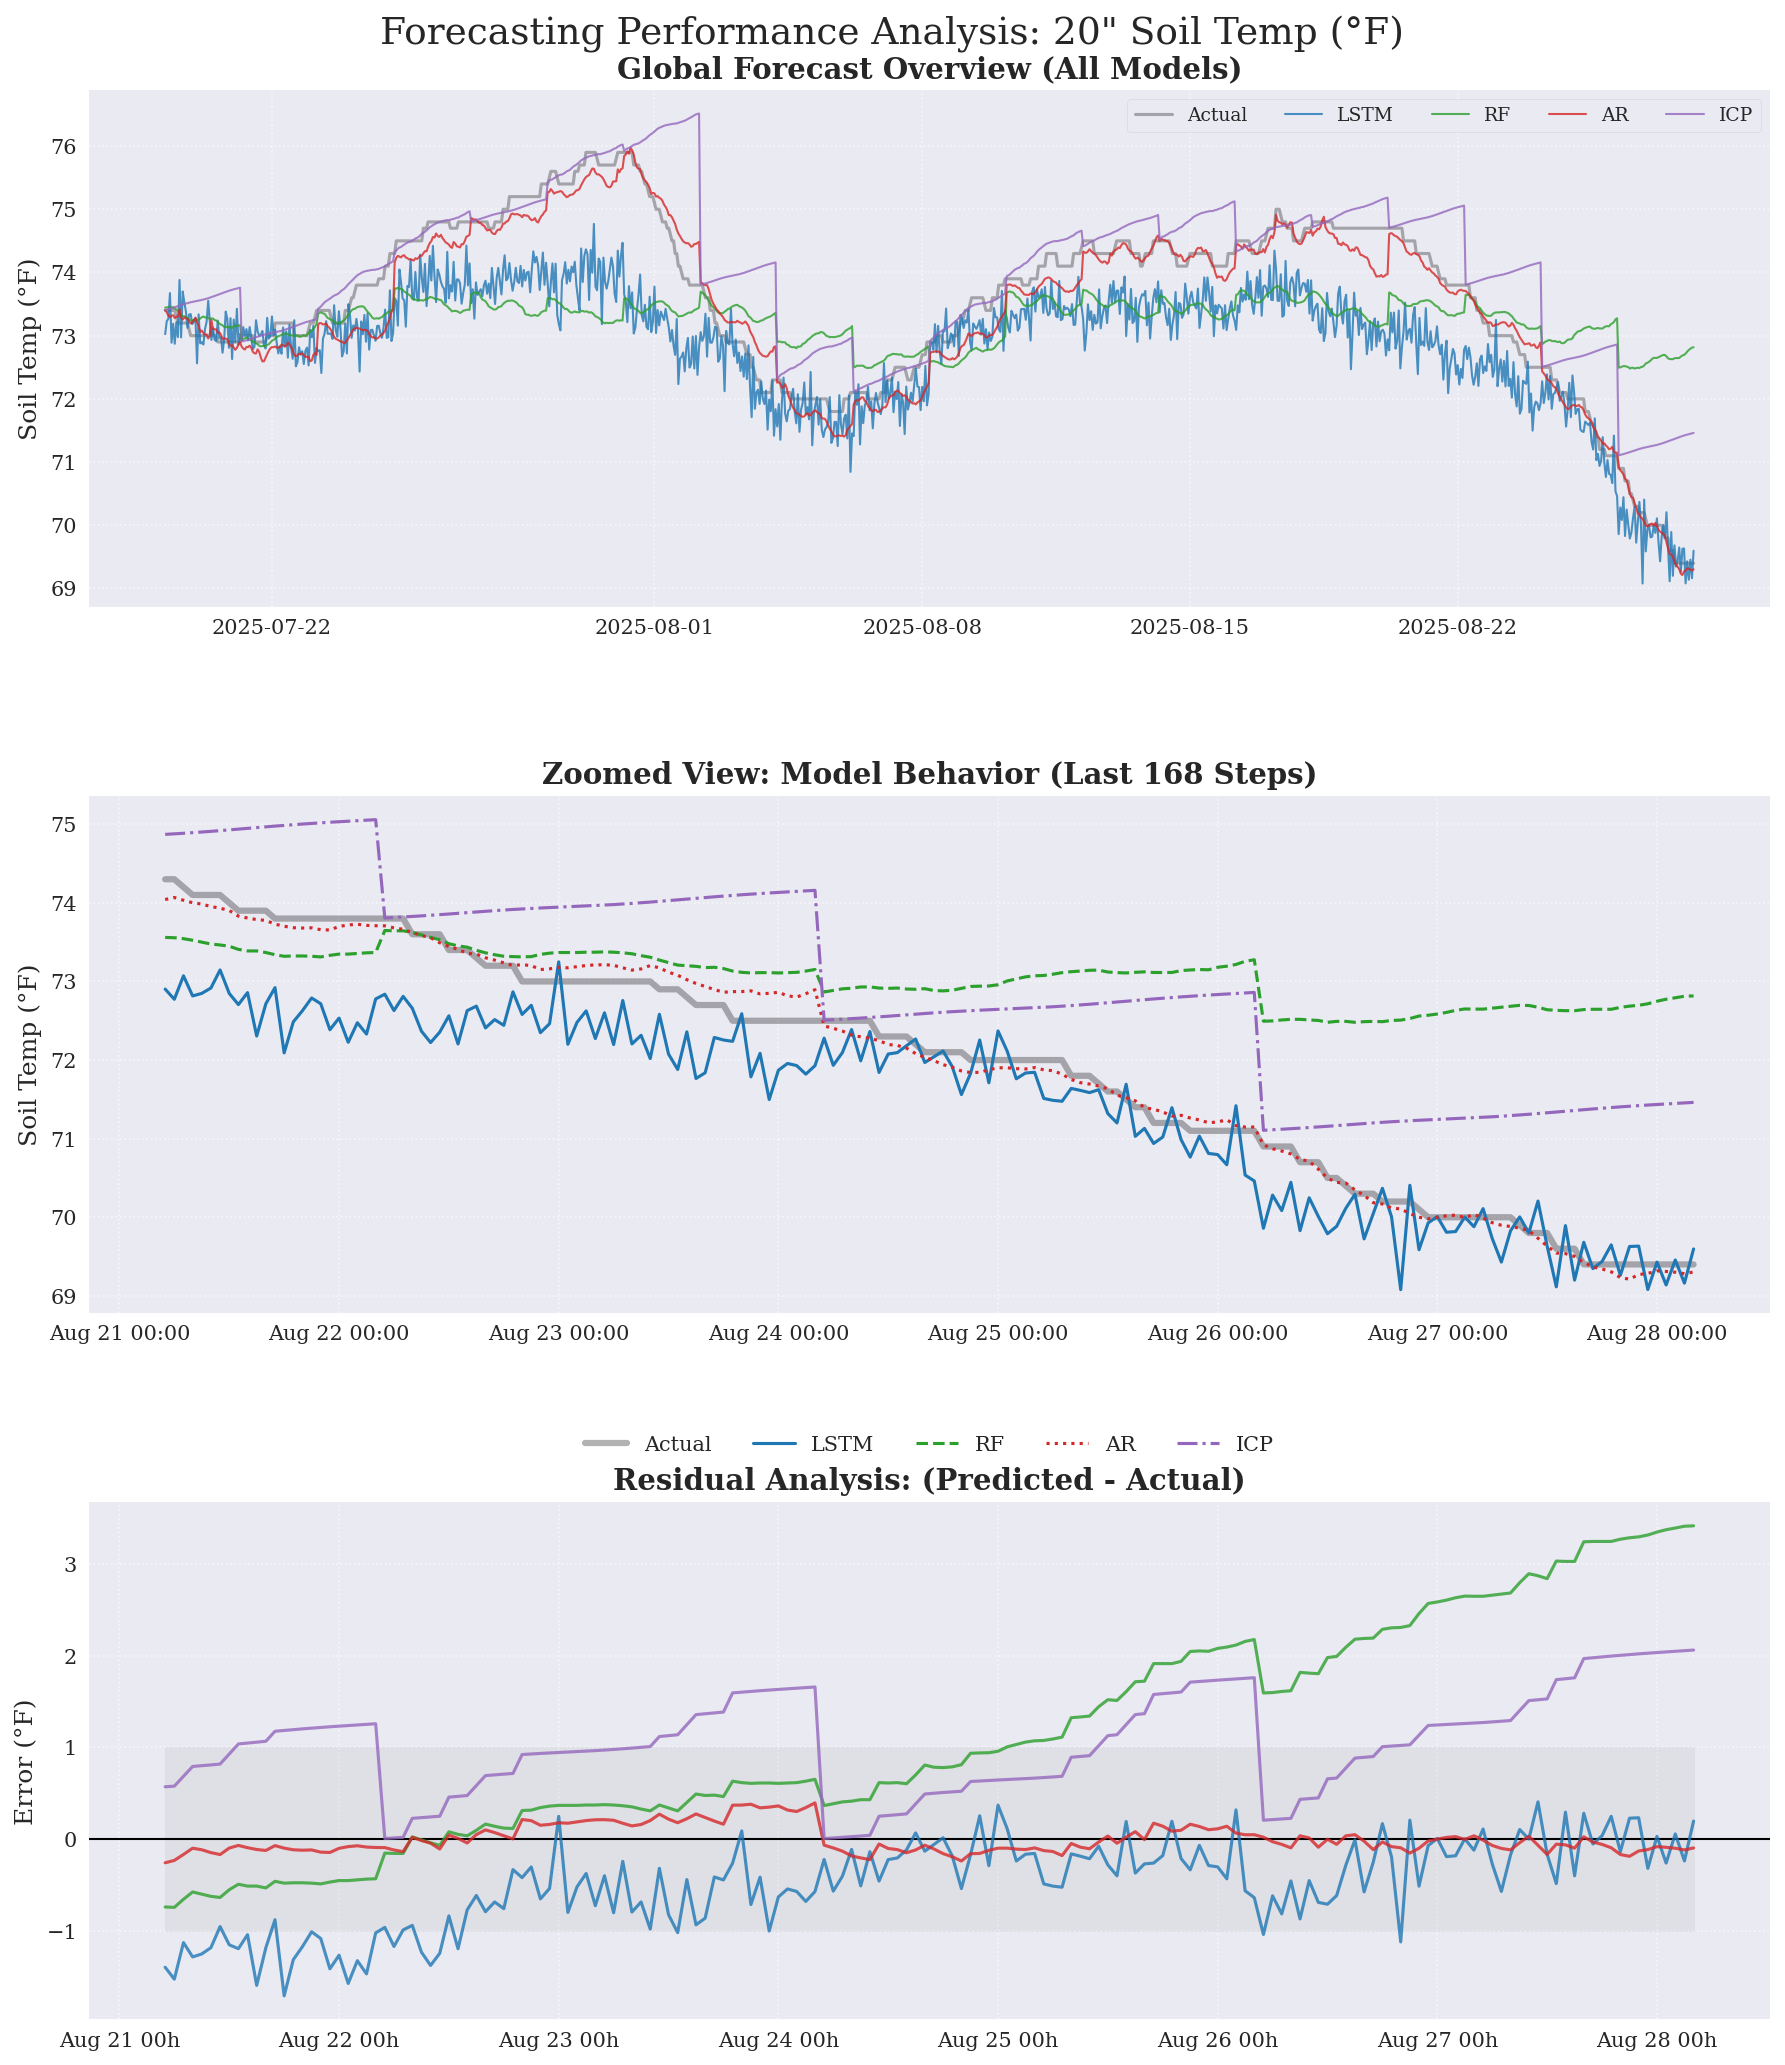

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# ==========================================
# 6. VISUALIZATION: TIME SERIES (ALL MODELS)
# ==========================================

# --- 1. Data Stitching ---
# Align dates with the test set targets
# Note: Ensure 'df.index' contains the timestamps for the target period
full_dates = df.index[train_size + SEQ_LENGTH:]

# Initialize lists to hold the stitched non-overlapping series
stitched_dates, stitched_actual = [], []
stitched_lstm, stitched_rf, stitched_ar, stitched_icp = [], [], [], []

# Stitch forecasts (Jump by FORECAST_HORIZON to create a continuous line without overlaps)
# This assumes real_y_test and preds are shape (samples, horizon)
for i in range(0, len(real_y_test), FORECAST_HORIZON):
    # Stop if we run out of data for a full horizon
    if i + FORECAST_HORIZON > len(real_y_test): 
        break
        
    # Slice the correct date chunk
    # Note: Depending on your data structure, you might need full_dates[i : i + FORECAST_HORIZON]
    # OR full_dates[i + shift : i + shift + FORECAST_HORIZON]
    chunk_dates = full_dates[i : i + FORECAST_HORIZON]
    
    stitched_dates.extend(chunk_dates)
    stitched_actual.extend(real_y_test[i])
    stitched_lstm.extend(real_lstm_preds[i])
    stitched_rf.extend(real_rf_preds[i])
    stitched_ar.extend(real_ar_preds[i])   
    stitched_icp.extend(real_icp_preds[i])

# Create Master DataFrame for easier plotting
results_df = pd.DataFrame({
    'Time': stitched_dates,
    'Actual': stitched_actual,
    'LSTM': stitched_lstm,
    'RF': stitched_rf,
    'AR': stitched_ar,    
    'ICP': stitched_icp
}).set_index('Time')

# --- 2. Plotting Setup ---
# 3 Rows: Global Context, Zoomed Detail, Error Analysis
fig, axes = plt.subplots(3, 1, figsize=(12, 14), sharex=False)
plt.subplots_adjust(hspace=0.4) # Increased slightly for date label readability

# Color Palette
colors = {'Actual': 'black', 'LSTM': '#1f77b4', 'RF': '#2ca02c', 'ICP': '#9467bd', 'AR': '#d62728'}

# --- Panel 1: Global View (Trend) ---
ax1 = axes[0]
ax1.plot(results_df.index, results_df['Actual'], color=colors['Actual'], alpha=0.3, label='Actual')
ax1.plot(results_df.index, results_df['LSTM'], color=colors['LSTM'], linewidth=1, alpha=0.8, label='LSTM')
ax1.plot(results_df.index, results_df['RF'],   color=colors['RF'],   linewidth=1, alpha=0.8, label='RF')
ax1.plot(results_df.index, results_df['AR'],   color=colors['AR'],   linewidth=1, alpha=0.8, label='AR') 
ax1.plot(results_df.index, results_df['ICP'],  color=colors['ICP'],  linewidth=1, alpha=0.8, label='ICP')

ax1.set_title('Global Forecast Overview (All Models)', fontsize=14, fontweight='bold')
ax1.set_ylabel('Soil Temp (°F)')
ax1.legend(loc='upper right', ncol=5, fontsize=9, frameon=True)
ax1.grid(True, linestyle=':', alpha=0.6)

# --- Panel 2: Zoomed View (Detail) ---
ax2 = axes[1]
# Select last 168 time steps (Assuming hourly data = 1 week)
zoom_steps = 168 if len(results_df) > 168 else len(results_df)
zoom_df = results_df.iloc[-zoom_steps:] 

ax2.plot(zoom_df.index, zoom_df['Actual'], color=colors['Actual'], linewidth=3, alpha=0.3, label='Actual')
ax2.plot(zoom_df.index, zoom_df['LSTM'], color=colors['LSTM'], linestyle='-',  linewidth=1.5, label='LSTM')
ax2.plot(zoom_df.index, zoom_df['RF'],   color=colors['RF'],   linestyle='--', linewidth=1.5, label='RF')
ax2.plot(zoom_df.index, zoom_df['AR'],   color=colors['AR'],   linestyle=':',  linewidth=1.5, label='AR') 
ax2.plot(zoom_df.index, zoom_df['ICP'],  color=colors['ICP'],  linestyle='-.', linewidth=1.5, label='ICP')

ax2.set_title(f'Zoomed View: Model Behavior (Last {zoom_steps} Steps)', fontsize=14, fontweight='bold')
ax2.set_ylabel('Soil Temp (°F)')
ax2.legend(ncol=5, loc='upper center', bbox_to_anchor=(0.5, -0.2), frameon=False)
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b %d %H:00'))
ax2.grid(True, linestyle=':', alpha=0.6)

# --- Panel 3: Residual Analysis (Error) ---
ax3 = axes[2]
ax3.axhline(0, color='black', linewidth=1, linestyle='-')

for model in ['LSTM', 'RF', 'AR', 'ICP']:
    residuals = zoom_df[model] - zoom_df['Actual']
    ax3.plot(zoom_df.index, residuals, color=colors[model], linewidth=1.5, alpha=0.8, label=model)

ax3.set_title('Residual Analysis: (Predicted - Actual)', fontsize=14, fontweight='bold')
ax3.set_ylabel('Error (°F)')
# Determine dynamic y-limits based on max error to keep fill_between visible
ax3.fill_between(zoom_df.index, -1, 1, color='gray', alpha=0.1, label='Target Accuracy (±1°F)')
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%b %d %Hh'))
ax3.grid(True, linestyle=':', alpha=0.6)

# Final Layout
plt.suptitle(f'Forecasting Performance Analysis: {TARGET_COL}', fontsize=18, y=0.98)
plt.tight_layout() # Helps prevent overlap
plt.show()


--- Processing Station: Close (Close.csv) ---
--- Loaded Close.csv: Shape (6528, 14) ---


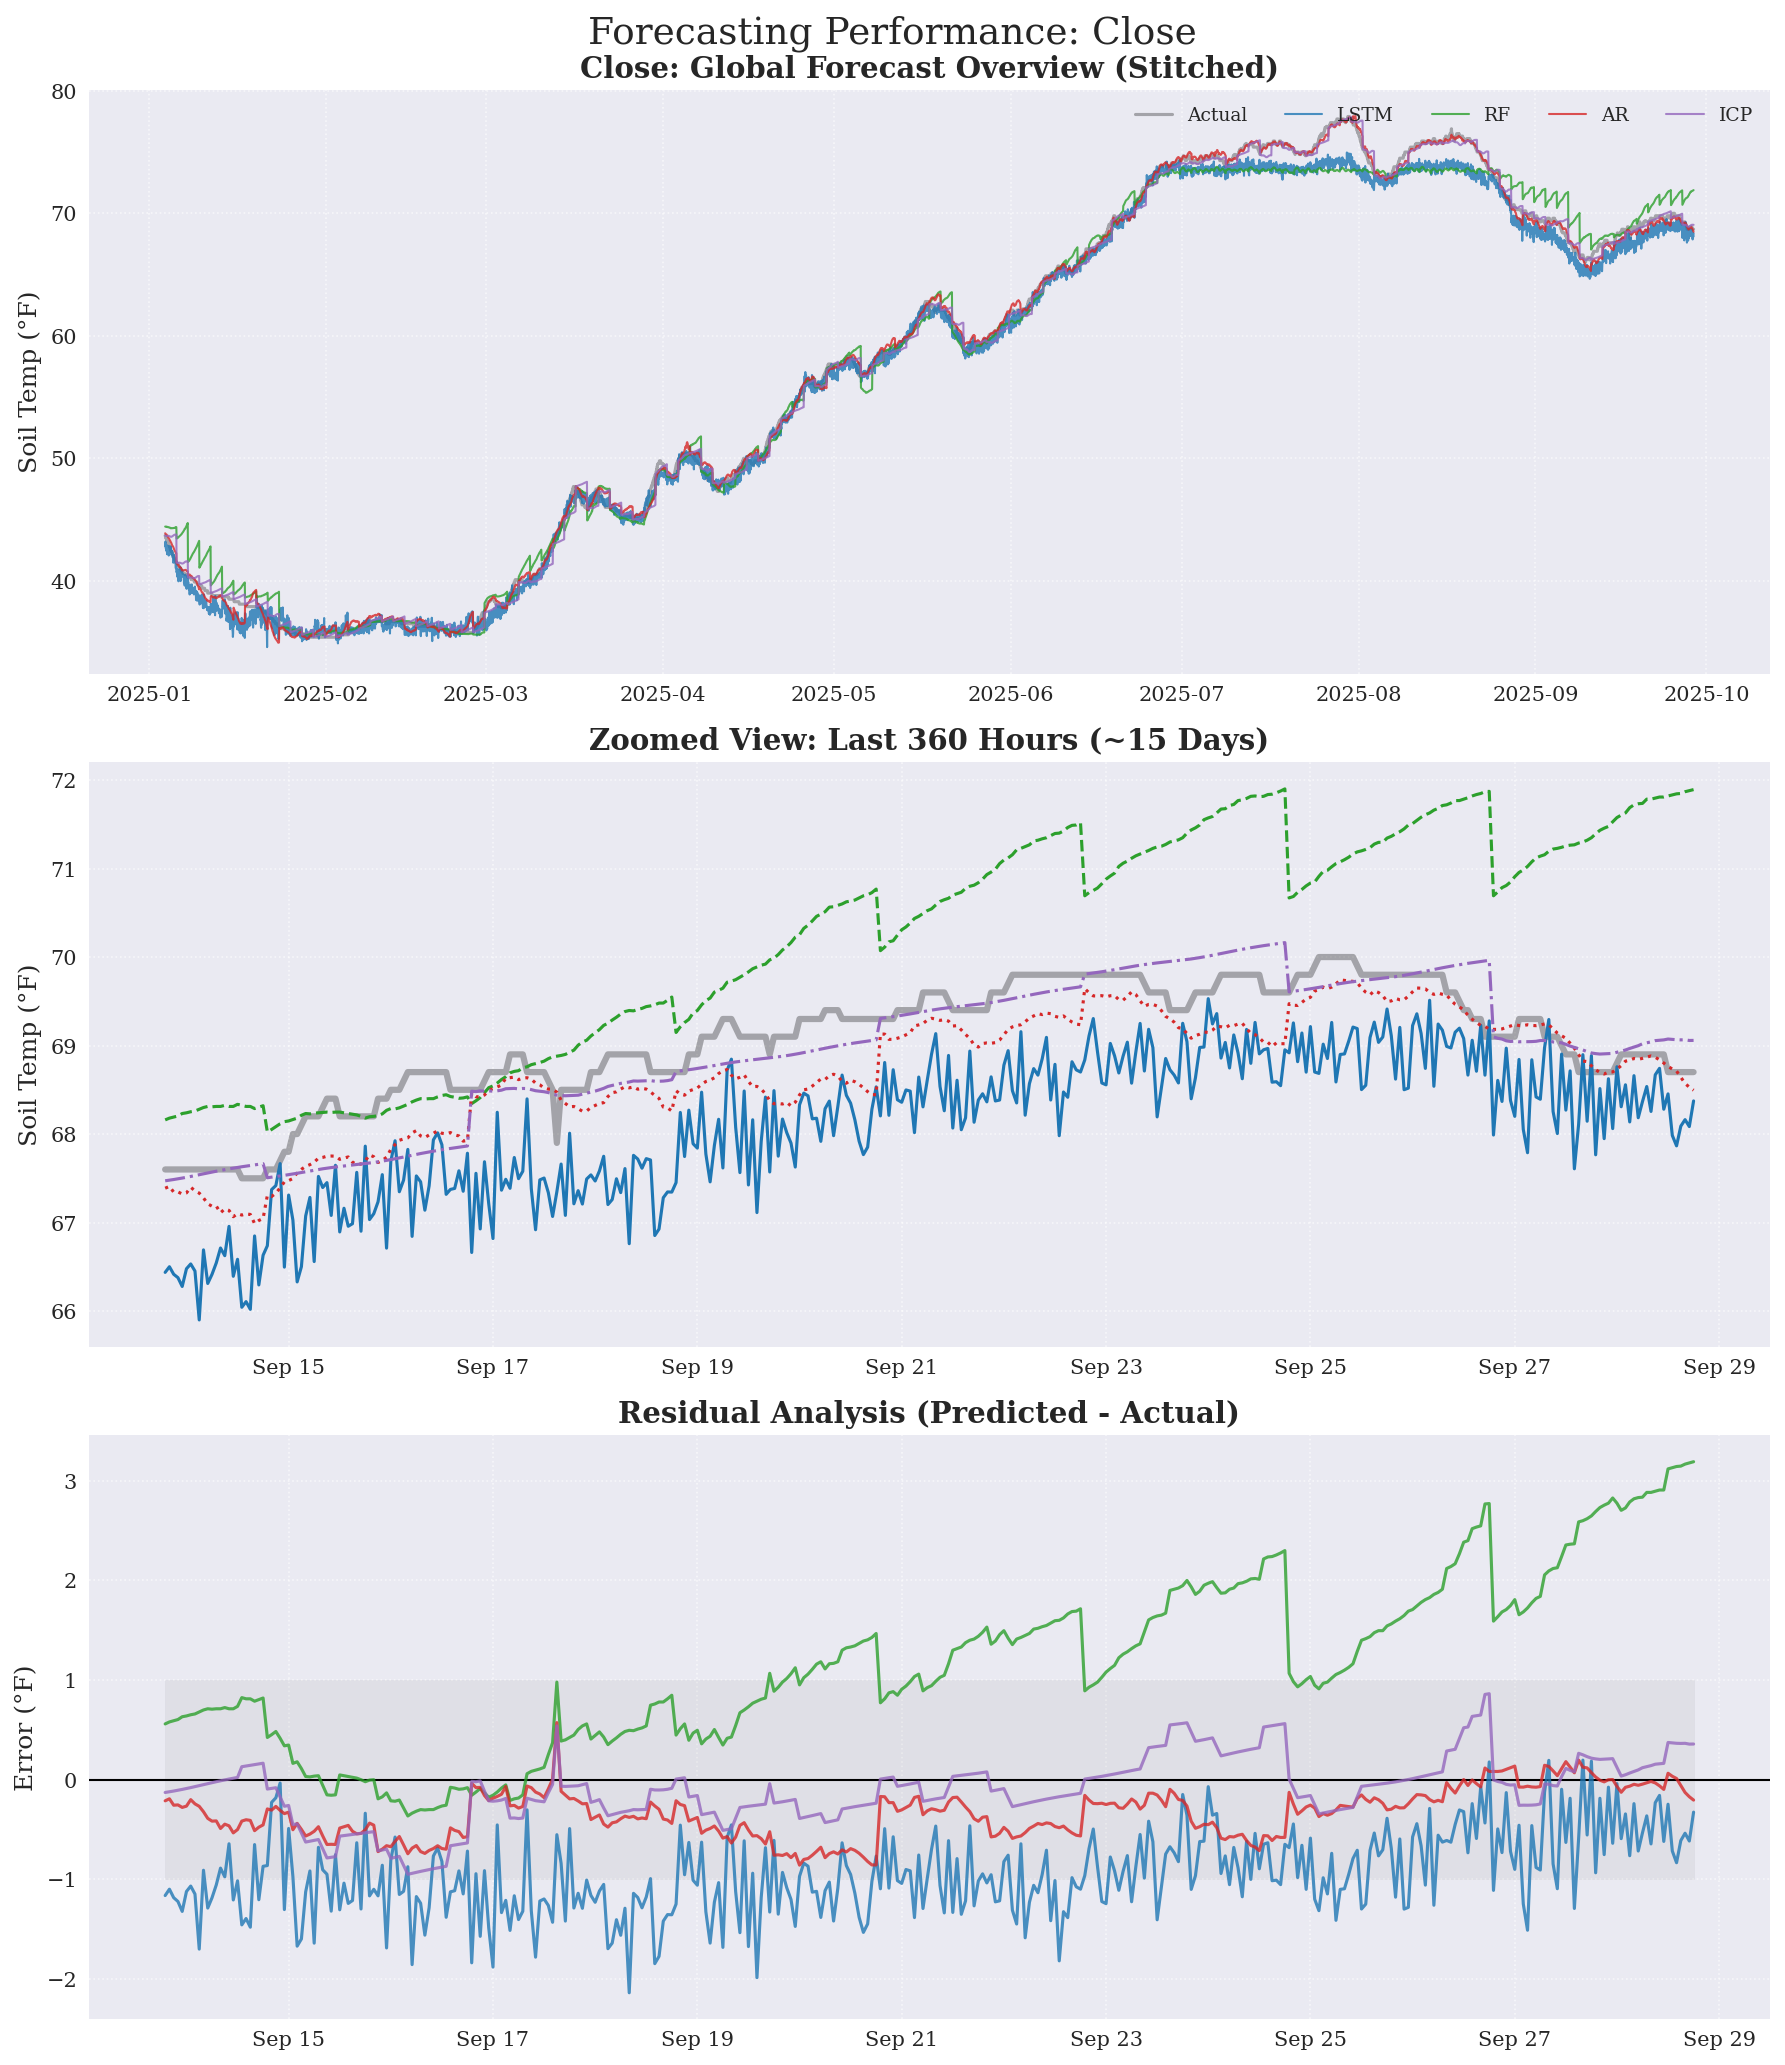


--- Processing Station: Far (Far.csv) ---
--- Loaded Far.csv: Shape (5808, 14) ---


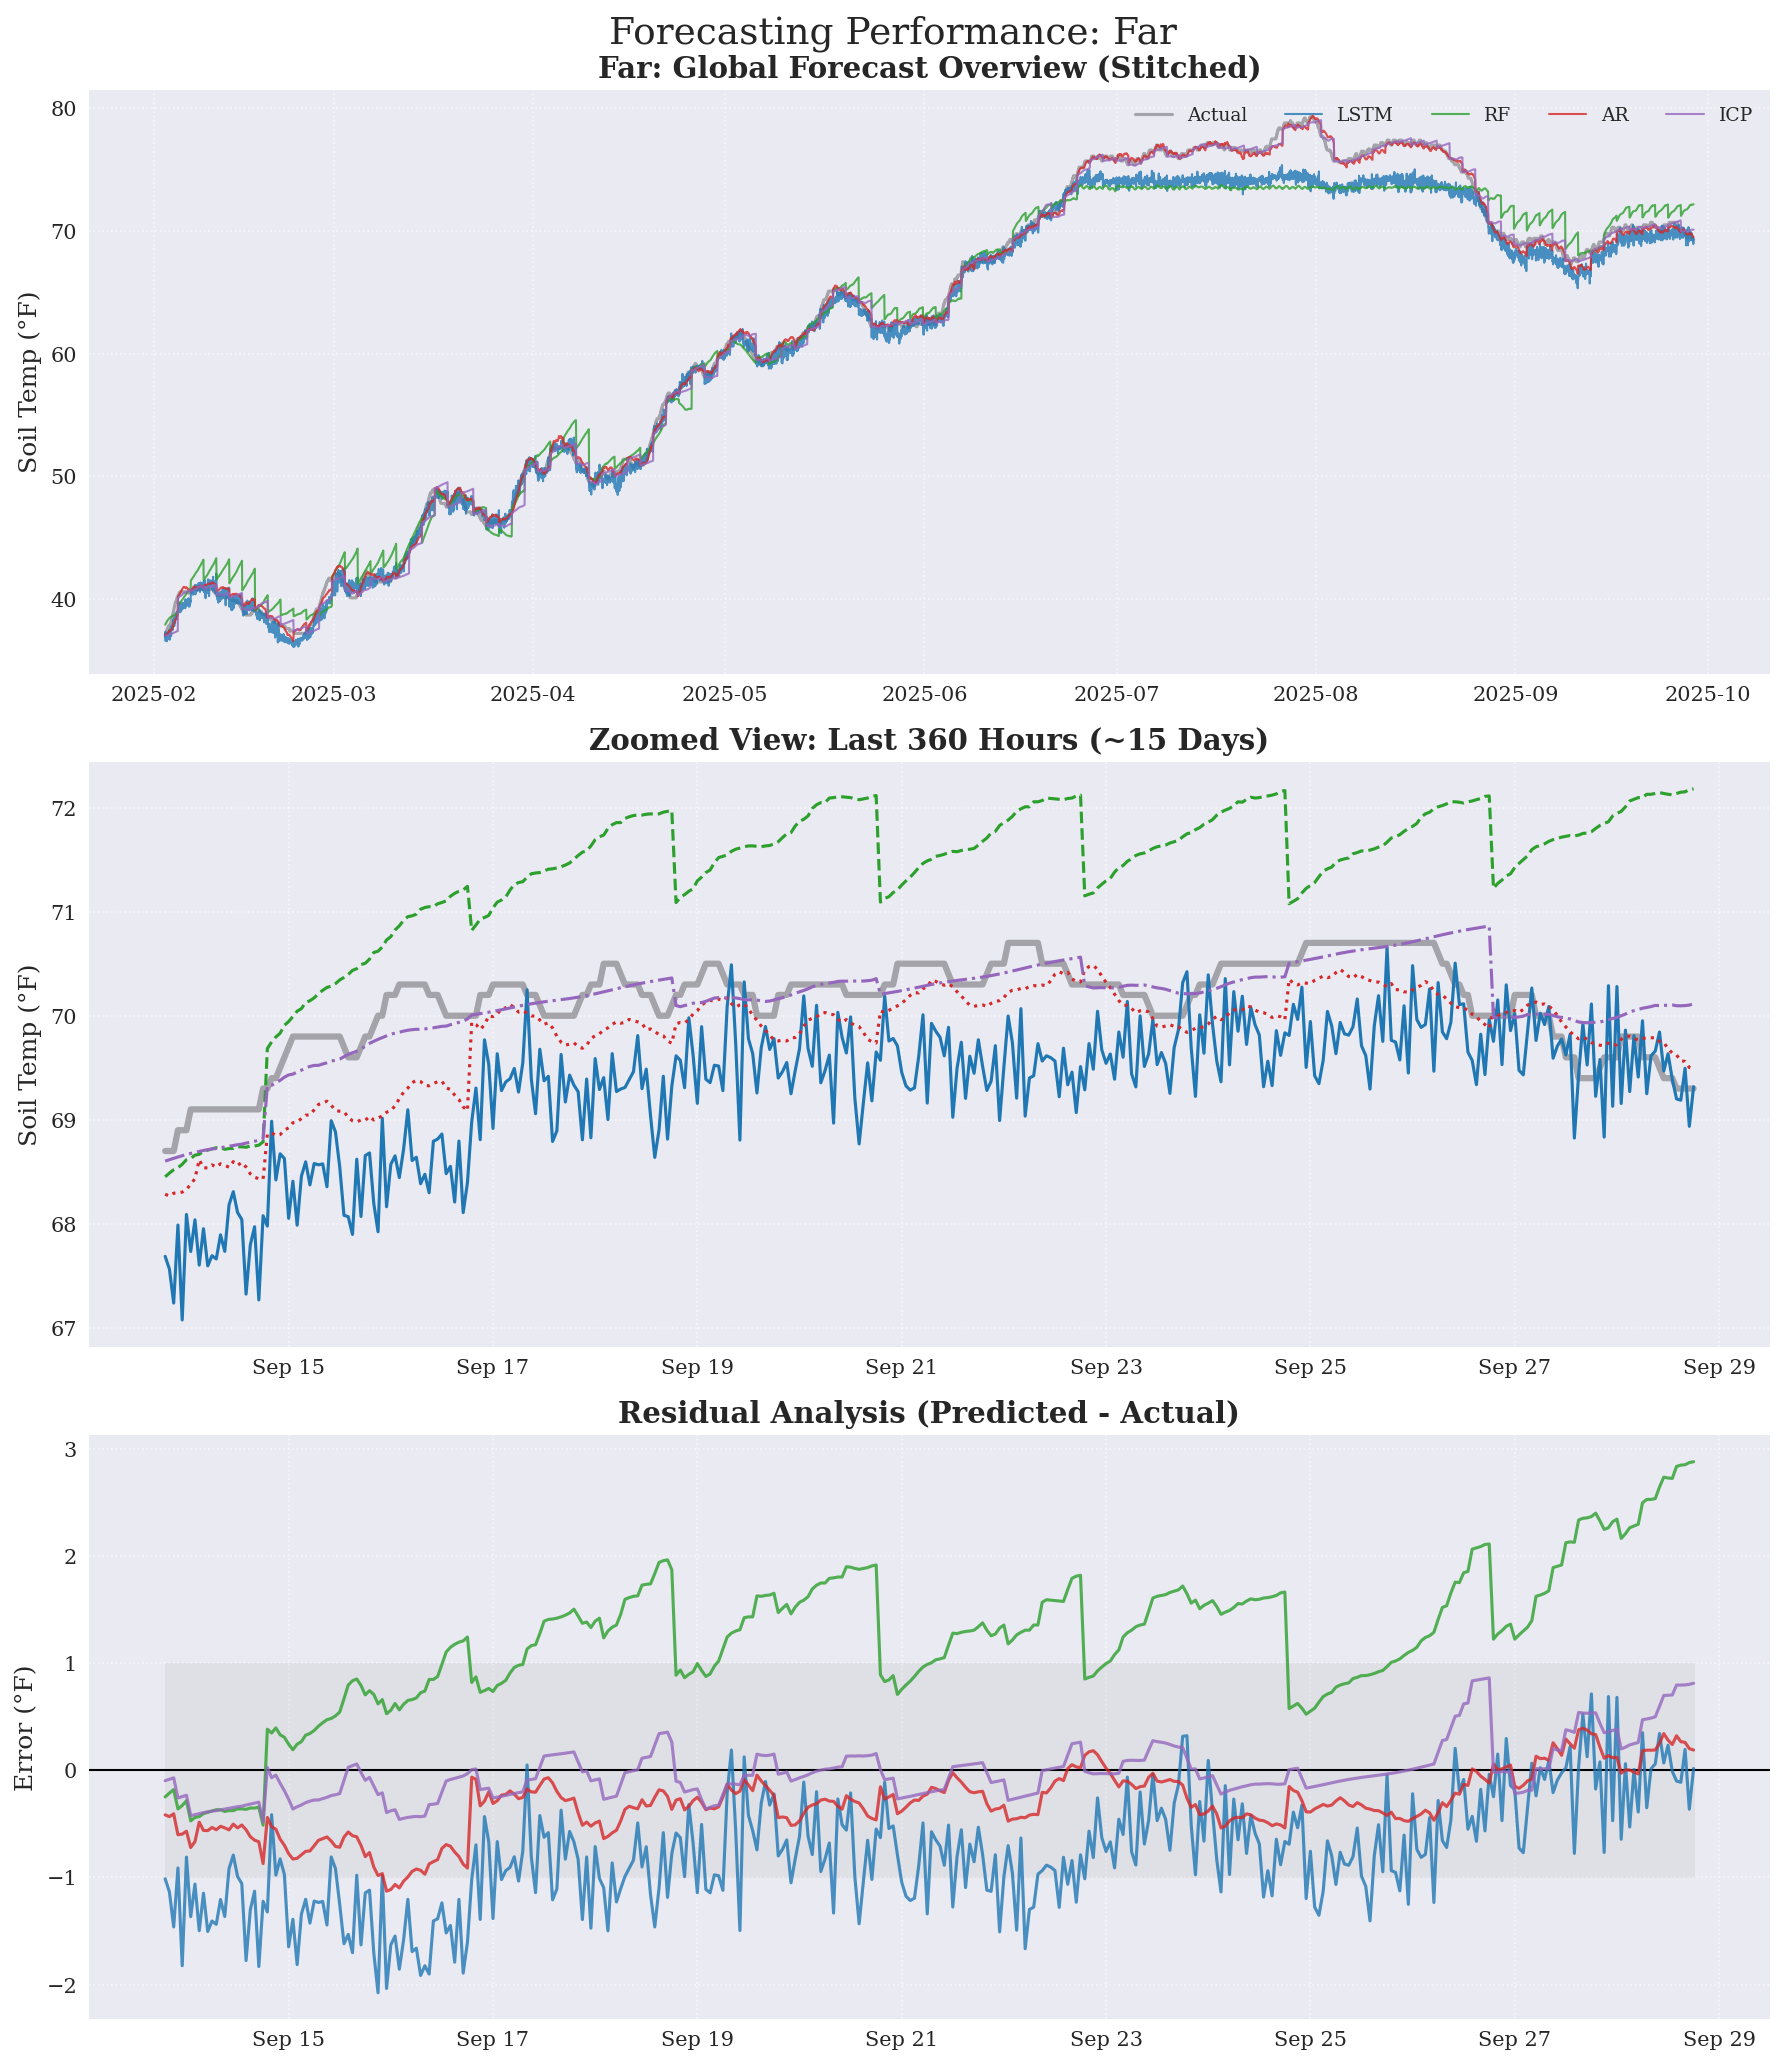


=== Global Analysis Compiled: 2332032 residuals collected ===

--- Final Performance Table (RMSE) ---
Model        LSTM        RF       ICP        AR
Station                                        
Close    1.082928  1.372080  0.573127  0.466588
Far      1.550660  2.025976  0.647083  0.446288


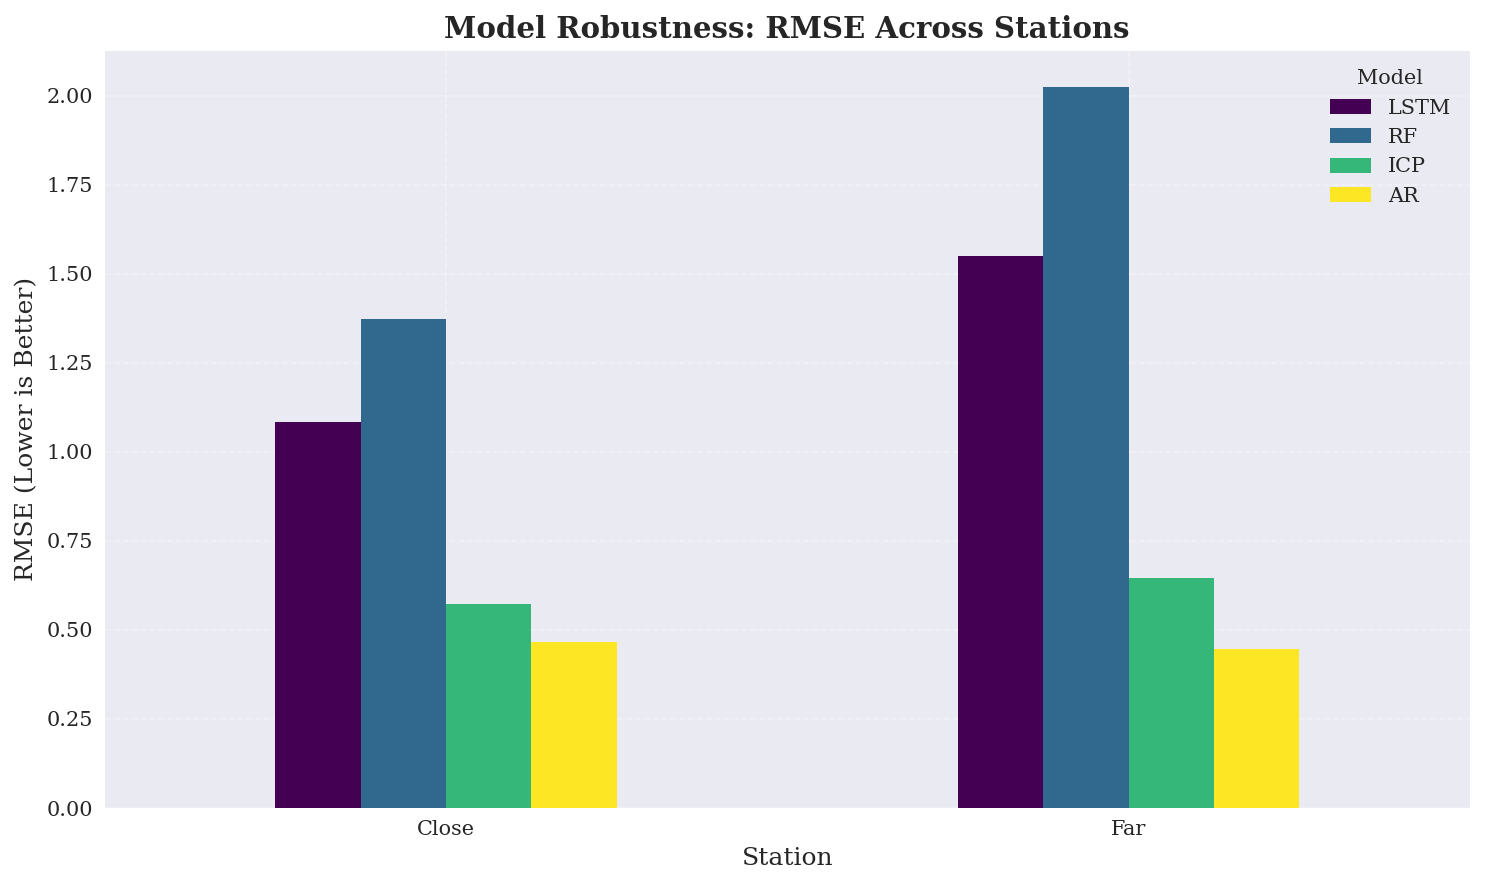

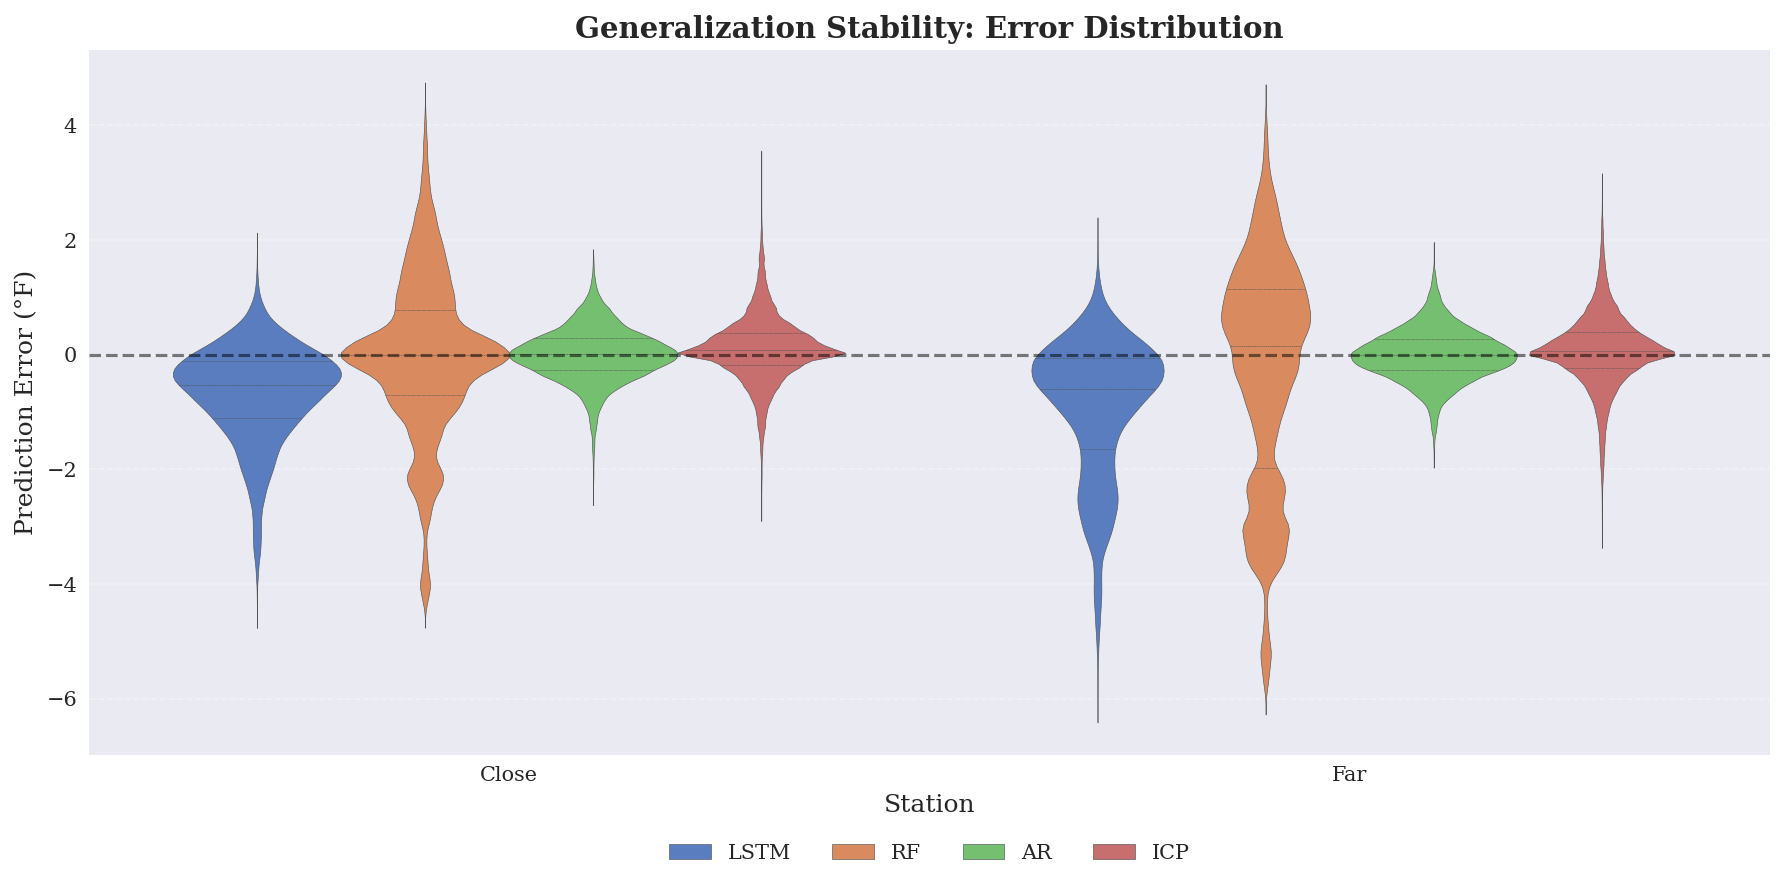

In [36]:
# ========================================================
# CONSOLIDATED MULTI-STATION ANALYSIS WITH STITCHED FORECASTS
# ========================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import torch

# 1. SETUP & HELPER FUNCTIONS
# ---------------------------
global_res_data = []

# Helper to Inverse Scale (Back to °F)
# Ensure 'scaler', 'target_idx', 'SEQ_LENGTH', 'FORECAST_HORIZON', 'DATE_COL', 'TARGET_COL' 
# are defined in your notebook from previous cells.
t_min = scaler.data_min_[target_idx]
t_max = scaler.data_max_[target_idx]
t_range = t_max - t_min

def inverse_t(scaled_data):
    return scaled_data * t_range + t_min

def process_station(filename, station_label):
    """
    Loads data, predicts, stitches 48h forecasts, plots the 3-panel dashboard,
    and collects residuals for the global table.
    """
    print(f"\n--- Processing Station: {station_label} ({filename}) ---")
    
    # A. Load & Filter Data
    try:
        df_new = load_and_filter_data(filename, DATE_COL, TARGET_COL)
    except Exception as e:
        print(f"Error loading {filename}: {e}")
        return

    if df_new.empty: 
        print("Dataframe is empty. Skipping.")
        return

    # B. Prepare Data (Scale & Sequence)
    # Use original scaler to test generalization
    new_data_scaled = scaler.transform(df_new.values)

    target_idx_new = df_new.columns.get_loc(TARGET_COL)
    weather_indices_new = [df_new.columns.get_loc(c) for c in df_new.columns if c != TARGET_COL]

    X_past, X_fut, y_true = create_sequences_with_future(
        new_data_scaled, SEQ_LENGTH, FORECAST_HORIZON, target_idx_new, weather_indices_new
    )

    if len(X_past) == 0:
        print("Not enough data to create sequences.")
        return

    # Prepare inputs
    t_X_past = torch.from_numpy(X_past).float()
    t_X_fut = torch.from_numpy(X_fut).float()
    
    X_past_flat = X_past.reshape(X_past.shape[0], -1)
    X_fut_flat = X_fut.reshape(X_fut.shape[0], -1)
    X_combined = np.hstack([X_past_flat, X_fut_flat])

    # C. Generate Predictions & Inverse Transform
    # -------------------------------------------
    # LSTM
    trained_lstm_model.eval()
    with torch.no_grad():
        lstm_out = trained_lstm_model(t_X_past, t_X_fut).numpy()
    pred_lstm = inverse_t(lstm_out)

    # Linear Models
    pred_rf = inverse_t(rf_model.predict(X_combined))
    pred_ar = inverse_t(ar_model.predict(X_combined))
    pred_icp = inverse_t(icp_model.predict(X_combined))
    
    # Actuals
    real_y = inverse_t(y_true)

    # D. Collect Residuals for Global Analysis (Method: Sliding Window)
    # We keep this for the detailed RMSE table as it covers every possible window
    models_dict = {'LSTM': pred_lstm, 'RF': pred_rf, 'AR': pred_ar, 'ICP': pred_icp}
    for model_name, preds in models_dict.items():
        residuals = (preds - real_y).flatten()
        for r in residuals:
            global_res_data.append({'Station': station_label, 'Model': model_name, 'Residual': r})

    # E. STITCHING FORECASTS (Method: Non-Overlapping Chunks)
    # -------------------------------------------------------
    # We jump by FORECAST_HORIZON to create a continuous operational timeline
    
    # Identify the full range of dates corresponding to the targets
    # Targets start at SEQ_LENGTH
    full_dates = df_new.index[SEQ_LENGTH:]
    
    # Initialize lists
    stitched_dates, stitched_actual = [], []
    stitched_lstm, stitched_rf, stitched_ar, stitched_icp = [], [], [], []

    # Loop with stride = FORECAST_HORIZON
    for i in range(0, len(real_y), FORECAST_HORIZON):
        # Stop if incomplete horizon
        if i + FORECAST_HORIZON > len(real_y):
            break
        
        # Get date chunk
        chunk_dates = full_dates[i : i + FORECAST_HORIZON]
        
        stitched_dates.extend(chunk_dates)
        stitched_actual.extend(real_y[i])
        stitched_lstm.extend(pred_lstm[i])
        stitched_rf.extend(pred_rf[i])
        stitched_ar.extend(pred_ar[i])
        stitched_icp.extend(pred_icp[i])

    # Create Master DataFrame for Plotting
    results_df = pd.DataFrame({
        'Time': stitched_dates,
        'Actual': stitched_actual,
        'LSTM': stitched_lstm,
        'RF': stitched_rf,
        'AR': stitched_ar,
        'ICP': stitched_icp
    }).set_index('Time')

    # F. VISUALIZATION: 3-PANEL DASHBOARD
    # -----------------------------------
    if not results_df.empty:
        fig, axes = plt.subplots(3, 1, figsize=(12, 14), sharex=False)
        plt.subplots_adjust(hspace=0.4)

        colors = {'Actual': 'black', 'LSTM': '#1f77b4', 'RF': '#2ca02c', 'ICP': '#9467bd', 'AR': '#d62728'}

        # Panel 1: Global View
        ax1 = axes[0]
        ax1.plot(results_df.index, results_df['Actual'], color=colors['Actual'], alpha=0.3, label='Actual')
        ax1.plot(results_df.index, results_df['LSTM'], color=colors['LSTM'], linewidth=1, alpha=0.8, label='LSTM')
        ax1.plot(results_df.index, results_df['RF'],   color=colors['RF'],   linewidth=1, alpha=0.8, label='RF')
        ax1.plot(results_df.index, results_df['AR'],   color=colors['AR'],   linewidth=1, alpha=0.8, label='AR')
        ax1.plot(results_df.index, results_df['ICP'],  color=colors['ICP'],  linewidth=1, alpha=0.8, label='ICP')
        ax1.set_title(f'{station_label}: Global Forecast Overview (Stitched)', fontsize=14, fontweight='bold')
        ax1.set_ylabel('Soil Temp (°F)')
        ax1.legend(loc='upper right', ncol=5, fontsize=9)
        ax1.grid(True, linestyle=':', alpha=0.6)

        # Panel 2: Zoomed View (Last ~1/2 Month)
        ax2 = axes[1]
        # 15 days * 24 hours = 360 hours
        zoom_steps = 360 if len(results_df) > 360 else len(results_df)
        zoom_df = results_df.iloc[-zoom_steps:]
        
        ax2.plot(zoom_df.index, zoom_df['Actual'], color=colors['Actual'], linewidth=3, alpha=0.3, label='Actual')
        ax2.plot(zoom_df.index, zoom_df['LSTM'], color=colors['LSTM'], linestyle='-', label='LSTM')
        ax2.plot(zoom_df.index, zoom_df['RF'],   color=colors['RF'],   linestyle='--', label='RF')
        ax2.plot(zoom_df.index, zoom_df['AR'],   color=colors['AR'],   linestyle=':', label='AR')
        ax2.plot(zoom_df.index, zoom_df['ICP'],  color=colors['ICP'],  linestyle='-.', label='ICP')
        ax2.set_title(f'Zoomed View: Last {zoom_steps} Hours (~15 Days)', fontsize=14, fontweight='bold')
        ax2.set_ylabel('Soil Temp (°F)')
        ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
        ax2.grid(True, linestyle=':', alpha=0.6)

        # Panel 3: Residual Analysis (Matching Zoom Window)
        ax3 = axes[2]
        ax3.axhline(0, color='black', linewidth=1)
        for model in ['LSTM', 'RF', 'AR', 'ICP']:
            residuals_plot = zoom_df[model] - zoom_df['Actual']
            ax3.plot(zoom_df.index, residuals_plot, color=colors[model], alpha=0.8, label=model)
        
        ax3.set_title('Residual Analysis (Predicted - Actual)', fontsize=14, fontweight='bold')
        ax3.set_ylabel('Error (°F)')
        ax3.fill_between(zoom_df.index, -1, 1, color='gray', alpha=0.1, label='Target ±1°F')
        ax3.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
        ax3.grid(True, linestyle=':', alpha=0.6)

        plt.suptitle(f'Forecasting Performance: {station_label}', fontsize=18, y=0.98)
        plt.tight_layout()
        plt.show()

# 2. RUN ANALYSIS LOOP
# --------------------
STATION_FILES = ['Close.csv', 'Far.csv'] 

for f in STATION_FILES:
    station_name = f.replace('.csv', '') 
    process_station(f, station_name)

# ========================================================
# 3. GLOBAL ANALYSIS & METRICS
# ========================================================

if len(global_res_data) > 0:
    df_res = pd.DataFrame(global_res_data)
    print(f"\n=== Global Analysis Compiled: {len(df_res)} residuals collected ===")

    # A. RMSE Performance Table
    rmse_table = df_res.groupby(['Station', 'Model'])['Residual'].apply(
        lambda x: np.sqrt(np.mean(x**2))
    ).reset_index(name='RMSE')

    final_results = rmse_table.pivot(index='Station', columns='Model', values='RMSE')
    cols_to_order = [c for c in ['LSTM', 'RF', 'ICP', 'AR'] if c in final_results.columns]
    final_results = final_results[cols_to_order]
    
    print("\n--- Final Performance Table (RMSE) ---")
    print(final_results)

    # B. Visualizing Performance Degradation
    final_results.plot(kind='bar', figsize=(10, 6), colormap='viridis')
    plt.title('Model Robustness: RMSE Across Stations', fontsize=14, fontweight='bold')
    plt.ylabel('RMSE (Lower is Better)')
    plt.xticks(rotation=0)
    plt.legend(title='Model')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

    # C. Visualizing Uncertainty (Violin Plot)
    plt.figure(figsize=(12, 6))
    sns.violinplot(
        data=df_res, x='Station', y='Residual', hue='Model', 
        split=False, inner='quartile', palette='muted'
    )
    plt.axhline(0, color='black', linestyle='--', alpha=0.5)
    plt.title('Generalization Stability: Error Distribution', fontweight='bold')
    plt.ylabel('Prediction Error (°F)')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=4, frameon=False)
    plt.tight_layout()
    plt.show()

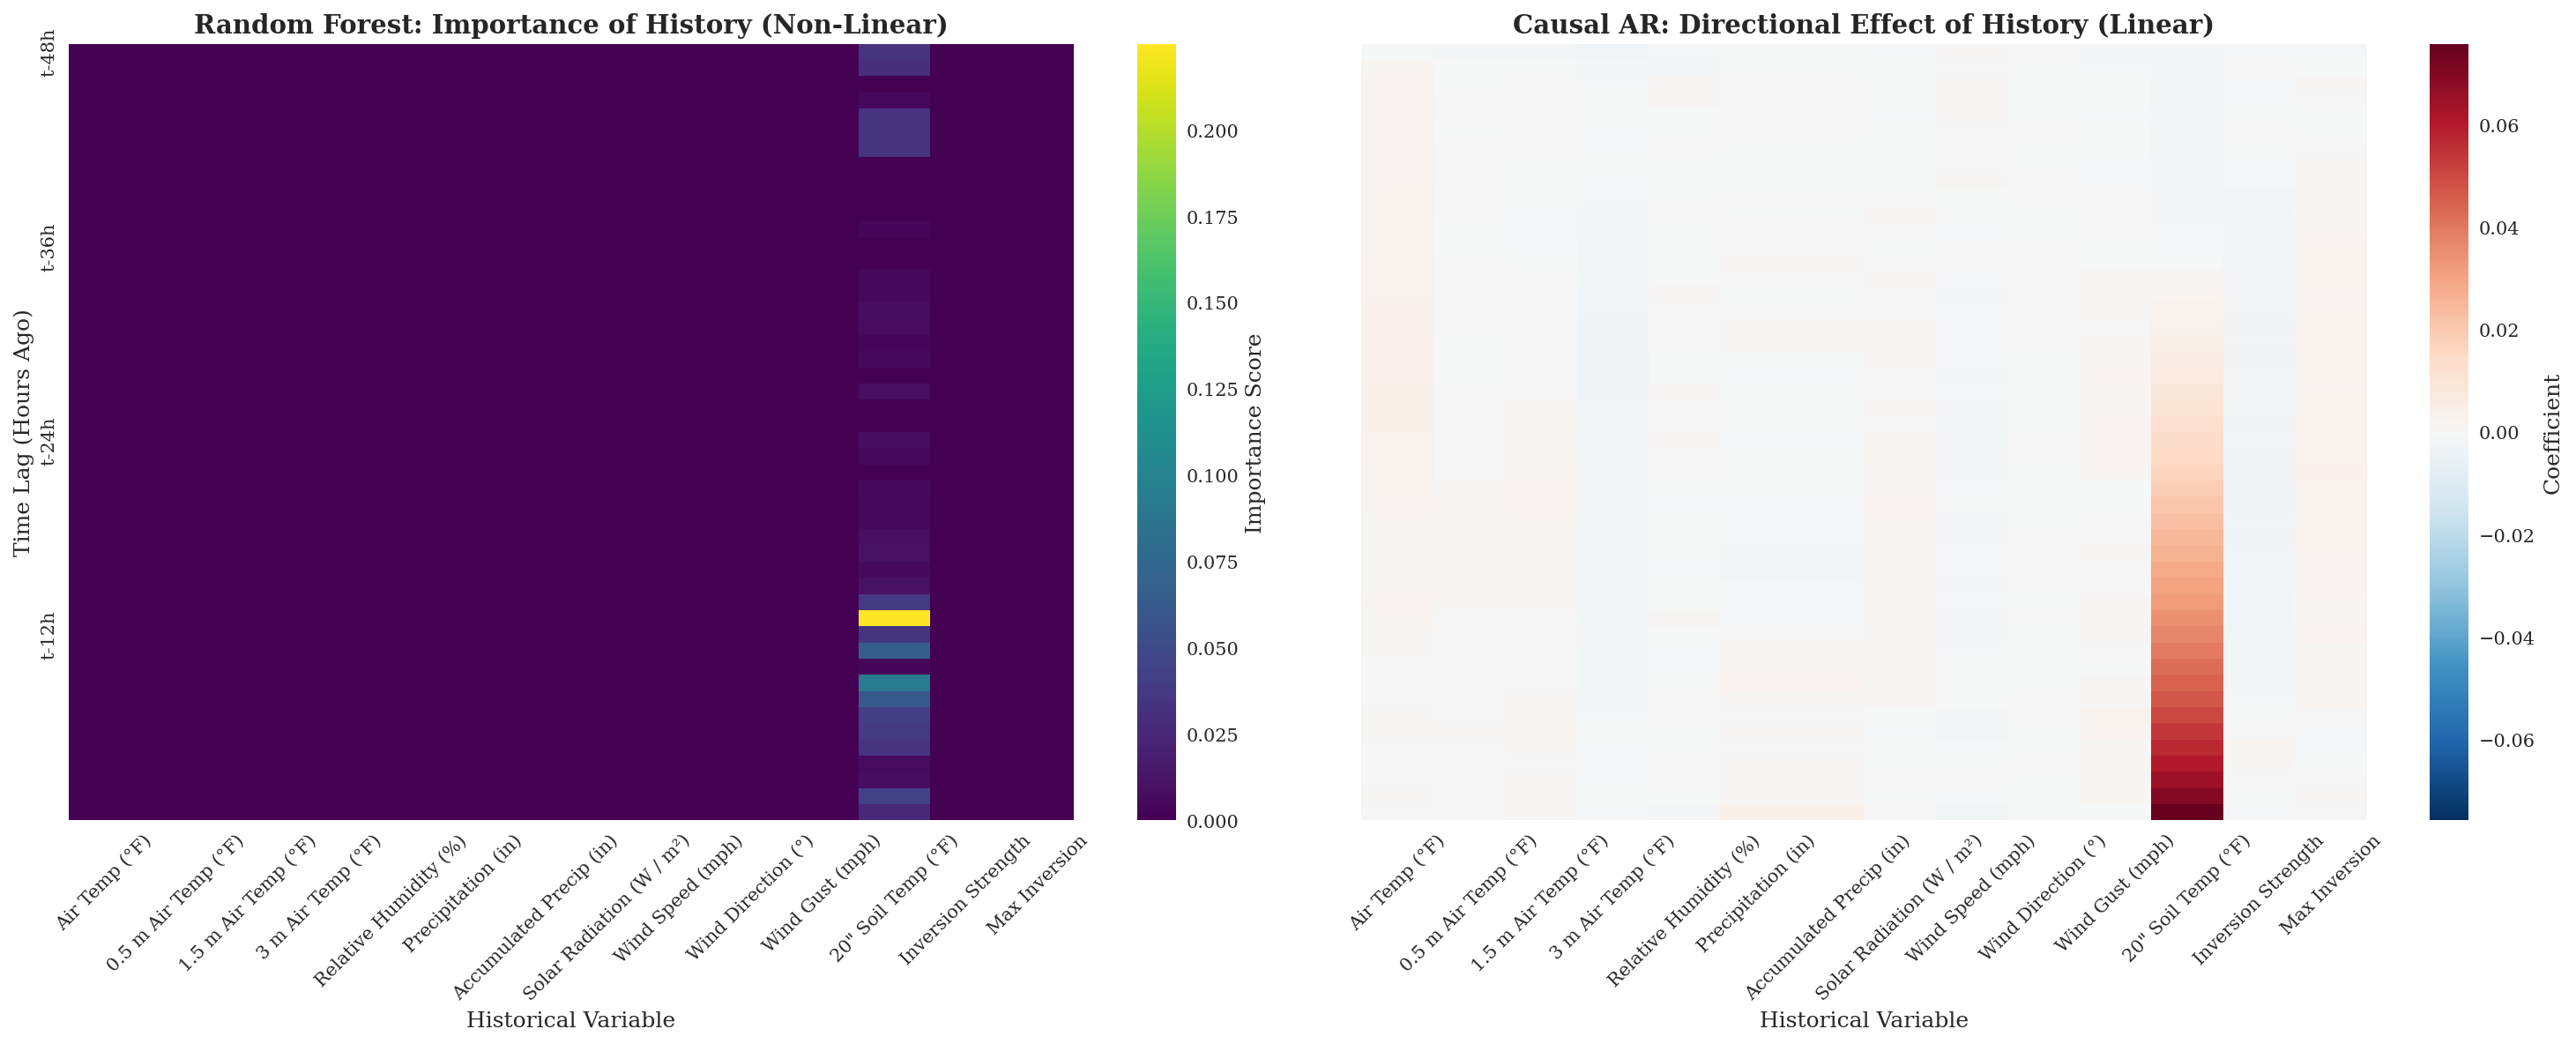

Interpretation: Comparison of how the Non-Linear model (Left) and Linear model (Right) utilize the past 48 hours of data.


In [32]:
# ========================================================
# FIGURE 3: Temporal Feature Importance (History Only)
# ========================================================

# 1. Setup Dimensions
raw_cols = df.columns.tolist() 
num_features = len(raw_cols)

# This is the size of the "History" block (48 hours * 14 variables)
n_history_elements = SEQ_LENGTH * num_features 

# Y-axis labels
y_ticks = [f"t-{i}h" if i % 12 == 0 else "" for i in range(SEQ_LENGTH, 0, -1)]

# 2. Slice the Data (Fixing the Error)
# ------------------------------------

# --- Random Forest ---
# The full array is size 1920. We take the first 672 elements (History).
importances_rf = rf_model.feature_importances_[:n_history_elements]
matrix_imp_rf = importances_rf.reshape(SEQ_LENGTH, num_features)

# --- Causal AR ---
# Same logic. We grab coefficients for the first prediction step (t+1), then slice.
coefs_ar = ar_model.estimators_[0].coef_[:n_history_elements]
matrix_coef_ar = coefs_ar.reshape(SEQ_LENGTH, num_features)

# 3. Plotting
# -----------
fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True)

# Panel A: Random Forest
sns.heatmap(
    matrix_imp_rf, 
    cmap="viridis", 
    xticklabels=raw_cols,
    yticklabels=y_ticks,
    cbar_kws={'label': 'Importance Score'},
    ax=axes[0]
)
axes[0].set_title('Random Forest: Importance of History (Non-Linear)', fontweight='bold')
axes[0].set_ylabel('Time Lag (Hours Ago)')
axes[0].set_xlabel('Historical Variable')
axes[0].tick_params(axis='x', rotation=45, labelsize=10)

# Panel B: Causal AR
max_val = np.max(np.abs(matrix_coef_ar))
sns.heatmap(
    matrix_coef_ar, 
    cmap="RdBu_r", 
    center=0,
    vmin=-max_val, vmax=max_val,
    xticklabels=raw_cols,
    yticklabels=y_ticks,
    cbar_kws={'label': 'Coefficient'},
    ax=axes[1]
)
axes[1].set_title('Causal AR: Directional Effect of History (Linear)', fontweight='bold')
axes[1].set_xlabel('Historical Variable')
axes[1].tick_params(axis='x', rotation=45, labelsize=10)

plt.tight_layout()
plt.show()

print("Interpretation: Comparison of how the Non-Linear model (Left) and Linear model (Right) utilize the past 48 hours of data.")

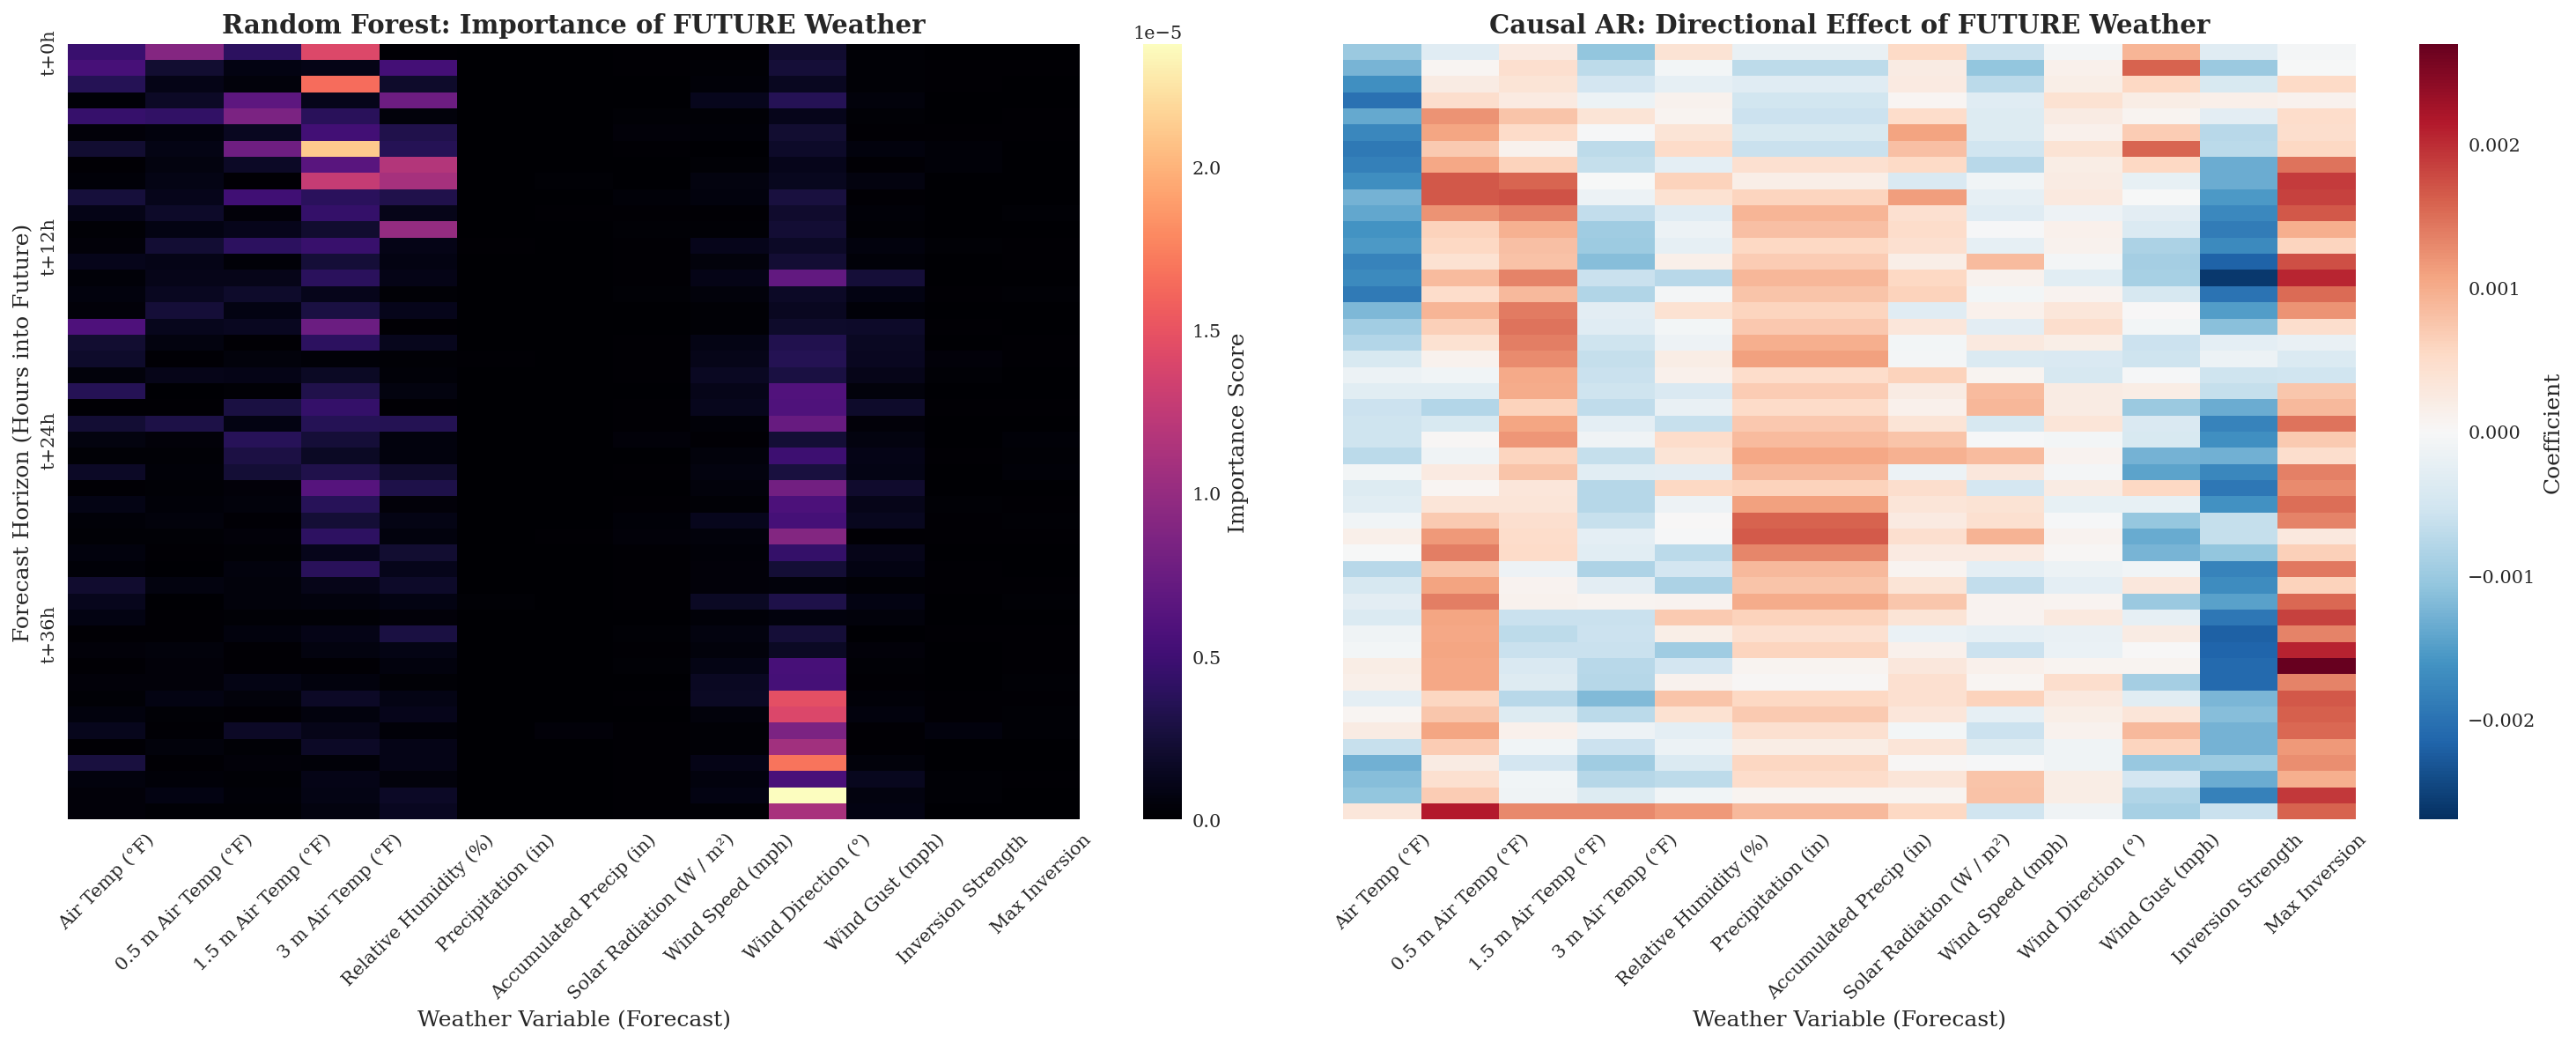

Interpretation:
- Look for bright spots. If 'Air Temp' or 'Solar Radiation' lights up at t+24h, t+48h, etc., the model is successfully using the weather forecast to guide its soil temp prediction.


In [33]:
# ========================================================
# FIGURE 3B: Future Weather Importance (Forecast Horizon)
# ========================================================

# 1. Setup Dimensions
# -------------------
# We need to distinguish between "History Features" (All 14 vars) 
# and "Future Weather Features" (13 vars, excluding Soil Temp)
history_cols = df.columns.tolist()
weather_cols = [c for c in history_cols if c != TARGET_COL]

n_history_elements = SEQ_LENGTH * len(history_cols)
n_future_elements = FORECAST_HORIZON * len(weather_cols)

# Y-axis for Future (t+1 to t+96)
y_ticks_future = [f"t+{i}h" if i % 12 == 0 else "" for i in range(0, FORECAST_HORIZON)]

# 2. Slice the Data for FUTURE
# ----------------------------

# --- Random Forest ---
# We take the slice AFTER history ends
importances_rf_fut = rf_model.feature_importances_[n_history_elements:]
matrix_imp_rf_fut = importances_rf_fut.reshape(FORECAST_HORIZON, len(weather_cols))

# --- Causal AR ---
coefs_ar_fut = ar_model.estimators_[0].coef_[n_history_elements:]
matrix_coef_ar_fut = coefs_ar_fut.reshape(FORECAST_HORIZON, len(weather_cols))

# 3. Plotting
# -----------
fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True)

# Panel A: Random Forest (Future)
sns.heatmap(
    matrix_imp_rf_fut, 
    cmap="magma",  # Different color to distinguish from history
    xticklabels=weather_cols,
    yticklabels=y_ticks_future,
    cbar_kws={'label': 'Importance Score'},
    ax=axes[0]
)
axes[0].set_title('Random Forest: Importance of FUTURE Weather', fontweight='bold')
axes[0].set_ylabel('Forecast Horizon (Hours into Future)')
axes[0].set_xlabel('Weather Variable (Forecast)')
axes[0].tick_params(axis='x', rotation=45)

# Panel B: Causal AR (Future)
max_val = np.max(np.abs(matrix_coef_ar_fut))
sns.heatmap(
    matrix_coef_ar_fut, 
    cmap="RdBu_r", 
    center=0,
    vmin=-max_val, vmax=max_val,
    xticklabels=weather_cols,
    yticklabels=y_ticks_future,
    cbar_kws={'label': 'Coefficient'},
    ax=axes[1]
)
axes[1].set_title('Causal AR: Directional Effect of FUTURE Weather', fontweight='bold')
axes[1].set_xlabel('Weather Variable (Forecast)')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("Interpretation:\n- Look for bright spots. If 'Air Temp' or 'Solar Radiation' lights up at t+24h, t+48h, etc., the model is successfully using the weather forecast to guide its soil temp prediction.")

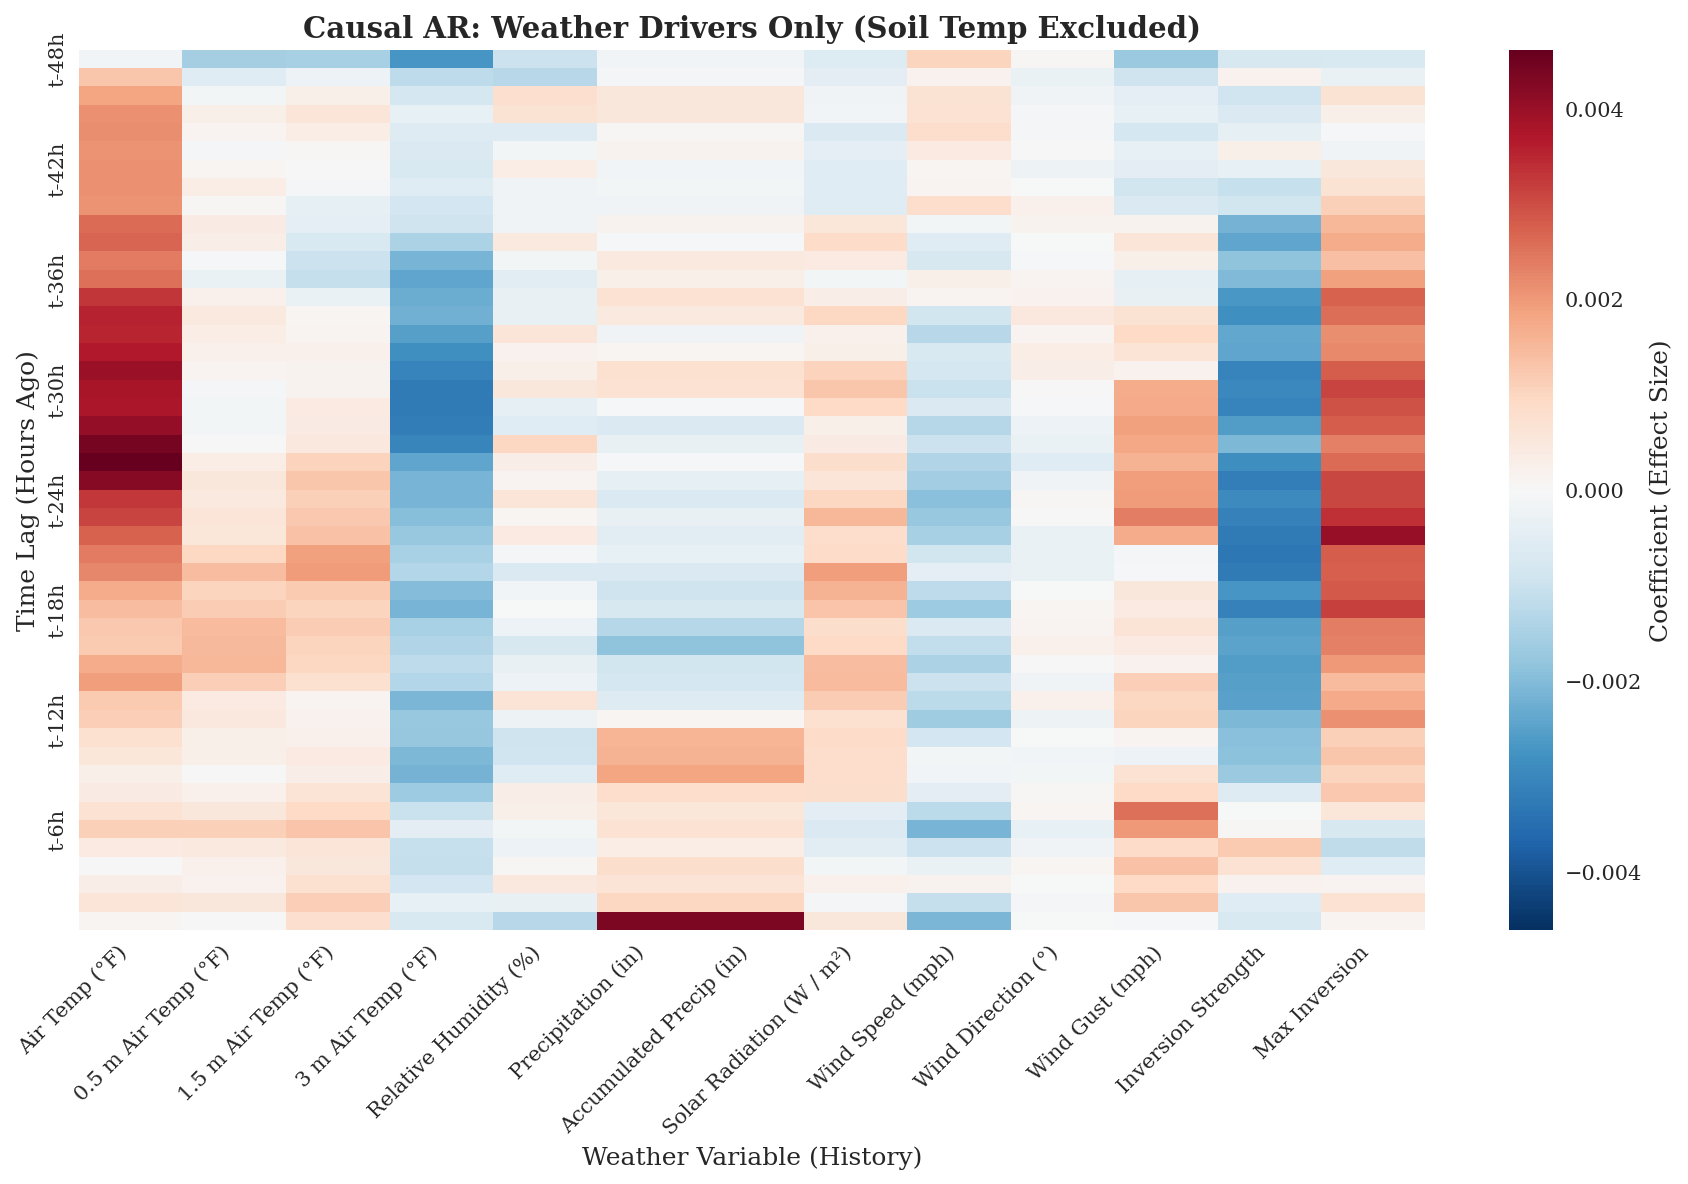

Max Coef for Soil Temp: 0.0758
Max Coef for Weather:   0.0046
Interpretation: The Soil Temp coefficient is likely ~0.9 (huge), while Weather is ~0.05 (small). Removing the huge bar allows us to see the red/blue bands indicating how Air Temp and Rain actually 'nudge' the prediction.


In [34]:
# ========================================================
# FIGURE 3C: Zooming in on Weather Drivers (Exclude Soil Temp)
# ========================================================

# 1. Setup Dimensions
# -------------------
history_cols = df.columns.tolist() # All 14 vars
weather_cols_only = [c for c in history_cols if c != TARGET_COL] # 13 vars (No Soil Temp)

# Find the index of the Soil Temp column to exclude it
soil_temp_idx = history_cols.index(TARGET_COL)

# 2. Extract Coefficients (History Only)
# --------------------------------------
# Get full history coefficients (Length = 48 * 14)
coefs_ar_full = ar_model.estimators_[0].coef_[:(SEQ_LENGTH * len(history_cols))]
# Reshape to (Time, Features)
matrix_ar_full = coefs_ar_full.reshape(SEQ_LENGTH, len(history_cols))

# 3. Drop the Soil Temp Column
# ----------------------------
# We delete the column corresponding to Soil Temp to see the rest
matrix_ar_weather = np.delete(matrix_ar_full, soil_temp_idx, axis=1)

# 4. Plotting
# -----------
plt.figure(figsize=(12, 8))

# Use a symmetric colormap centered on 0
max_val = np.max(np.abs(matrix_ar_weather))

sns.heatmap(
    matrix_ar_weather, 
    cmap="RdBu_r", 
    center=0,
    vmin=-max_val, vmax=max_val,
    xticklabels=weather_cols_only,
    yticklabels=[f"t-{i}h" if i%6==0 else "" for i in range(SEQ_LENGTH, 0, -1)],
    cbar_kws={'label': 'Coefficient (Effect Size)'}
)

plt.title('Causal AR: Weather Drivers Only (Soil Temp Excluded)', fontsize=14, fontweight='bold')
plt.xlabel('Weather Variable (History)')
plt.ylabel('Time Lag (Hours Ago)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print(f"Max Coef for Soil Temp: {np.max(np.abs(matrix_ar_full[:, soil_temp_idx])):.4f}")
print(f"Max Coef for Weather:   {max_val:.4f}")
print("Interpretation: The Soil Temp coefficient is likely ~0.9 (huge), while Weather is ~0.05 (small). Removing the huge bar allows us to see the red/blue bands indicating how Air Temp and Rain actually 'nudge' the prediction.")